Trey Tuscai and Gordon Doore

Spring 2025

CS 444: Deep Learning

Project 2: Branch Neural Networks

#### Week 2: Residual networks

The focus this week is on the ResNet architecture. You will build several neural networks in the ResNet family and and train them on CIFAR-10 and CIFAR-100.

In [1]:
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt

plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-darkgrid'])
plt.rcParams.update({'font.size': 20})

np.set_printoptions(suppress=True, precision=7)

# Automatically reload your external source code
%load_ext autoreload
%autoreload 2

2025-04-08 12:56:20.195064: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Task 6: The Residual Block

This task focuses on implementing and testing the **Residual Block** in preparation of creating the first ResNet (**ResNet-8**). 

Much like how Inception Blocks represent the building blocks of Inception Net, stacks of Residual Blocks represent the basis of ResNet. Residual Blocks possess a simpler structure than Inception Blocks — they only contain two parallel branches with fewer layers. Here is a refresher on the structure of the branches:

**Main branch:** sequence of two 2D convolutional layers.

**Residual branch:** the input signal to the Residual Block passes through "as-is", without modification (usually).

Like Inception Block, the output of both branches comes together at the end of the block. However, the branch outputs are SUMMED together rather than being concatenated.


This is the story for most Residual Blocks, however, like most CNNs:
1. the spatial resolution of the activations occasionally decreases
2. the number of conv filters/neurons increases

as we go deeper in a ResNet. Both of these factors tend to change *at the same time* in a small number of Residual Blocks located at various depths of the ResNet. Put another way, the spatial resolution and number of filters tends to remain constant across most successive Residual Blocks and they only changes in a few blocks throughout the net.
1. The decrease in spatial resolution is implemented in these small number of Residual Blocks with a convolutional stride > 1.
2. A 1x1 convolutional layer is needed as the "special sauce" along the residual branch to make the shapes of signals in both branches match (*otherwise they could not be summed!*).

### 6a. Implement and test the Residual Block

The class is in `residual_block.py`.

In [2]:
from residual_block import ResidualBlock

#### Test: `ResidualBlock` Stride 1 (1/2)

In [3]:
# Testing architecture and shapes
# Stride 1
tf.random.set_seed(0)
res1 = ResidualBlock('TestResidualBlock_S1', 7, prev_layer_or_block=None, strides=1)
res1(tf.ones([1, 4, 4, 7]))
print(res1)

TestResidualBlock_S1:
	Conv2D layer output(TestResidualBlock_S1/main_3x3conv_2) shape: [1, 4, 4, 7]
	Conv2D layer output(TestResidualBlock_S1/main_3x3conv_1) shape: [1, 4, 4, 7]


The above cell should print:

```
TestResidualBlock_S1:
	Conv2D layer output(TestResidualBlock_S1/main_3x3conv_2) shape: [1, 4, 4, 7]
	Conv2D layer output(TestResidualBlock_S1/main_3x3conv_1) shape: [1, 4, 4, 7]
```

In [4]:
# Test activations
tf.random.set_seed(0)
net_acts1 = res1(tf.random.uniform([2, 4, 4, 7]))
print(f'The shape of the netAct output from the block is {net_acts1.shape} and should be (2, 4, 4, 7)')
print(f'The first few activations are:\n{net_acts1[0,:,:, 0]}')
print('and should be:')
print('''[[0.        0.520823  0.1888617 0.       ]
 [0.        0.7621396 0.1734907 0.8486798]
 [0.        0.6156113 0.4272216 0.       ]
 [0.5561852 0.4888234 1.0138503 0.5533389]]''')

The shape of the netAct output from the block is (2, 4, 4, 7) and should be (2, 4, 4, 7)
The first few activations are:
[[0.        0.5208229 0.1888617 0.       ]
 [0.        0.7621395 0.1734906 0.8486798]
 [0.        0.6156111 0.4272216 0.       ]
 [0.5561852 0.4888234 1.0138503 0.5533389]]
and should be:
[[0.        0.520823  0.1888617 0.       ]
 [0.        0.7621396 0.1734907 0.8486798]
 [0.        0.6156113 0.4272216 0.       ]
 [0.5561852 0.4888234 1.0138503 0.5533389]]


#### Test: `ResidualBlock` Stride 2 (2/2)

In [5]:
# Testing architecture and shapes
# Stride 2
tf.random.set_seed(0)
res2 = ResidualBlock('TestResidualBlock_S2', 5, prev_layer_or_block=None, strides=2)
res2(tf.ones([1, 6, 6, 5]))
print(res2)

TestResidualBlock_S2:
	Conv2D layer output(TestResidualBlock_S2/main_3x3conv_2) shape: [1, 3, 3, 5]
	Conv2D layer output(TestResidualBlock_S2/main_3x3conv_1) shape: [1, 3, 3, 5]
	-->Conv2D1x1 layer output(TestResidualBlock_S2/skip_conv1x1) shape: [1, 3, 3, 5]-->


The above cell should print:

```
TestResidualBlock_S2:
	Conv2D layer output(TestResidualBlock_S2/main_3x3conv_2) shape: [1, 3, 3, 5]
	Conv2D layer output(TestResidualBlock_S2/main_3x3conv_1) shape: [1, 3, 3, 5]
	-->Conv2D1x1 layer output(TestResidualBlock_S2/skip_conv1x1) shape: [1, 3, 3, 5]-->
```

*The layer with the --> is the residual branch.*

In [6]:
# Test activations
tf.random.set_seed(0)
net_acts2 = res2(tf.random.uniform([3, 6, 6, 5]))
print(f'The shape of the netAct output from the block is {net_acts2.shape} and should be (3, 3, 3, 5)')
print(f'The first few activations are:\n{net_acts2[0,:,:, :]}')
print('and should be:')
print('''[[[0.2404823 0.        0.        0.2851936 0.       ]
  [0.        0.        0.        0.1339086 0.6898913]
  [0.        0.        0.        0.4596353 0.2781557]]

 [[0.        0.        0.        0.6591434 1.3703969]
  [0.2665227 0.        0.        0.9614864 0.       ]
  [0.        0.        0.        0.3844326 0.7111533]]

 [[0.0933782 0.        0.        0.1378801 0.3006183]
  [0.1873689 0.        0.        0.4464224 1.1067129]
  [0.        0.        0.        0.7910071 0.345379 ]]]''')

The shape of the netAct output from the block is (3, 3, 3, 5) and should be (3, 3, 3, 5)
The first few activations are:
[[[0.2403669 0.        0.        0.2852962 0.       ]
  [0.        0.        0.        0.133912  0.689717 ]
  [0.        0.        0.        0.4595791 0.2781493]]

 [[0.        0.        0.        0.659112  1.3700997]
  [0.2664362 0.        0.        0.9615825 0.       ]
  [0.        0.        0.        0.3844297 0.7109974]]

 [[0.0933684 0.        0.        0.1379156 0.3004903]
  [0.1871757 0.        0.        0.4464865 1.1061925]
  [0.        0.        0.        0.7911265 0.3450609]]]
and should be:
[[[0.2404823 0.        0.        0.2851936 0.       ]
  [0.        0.        0.        0.1339086 0.6898913]
  [0.        0.        0.        0.4596353 0.2781557]]

 [[0.        0.        0.        0.6591434 1.3703969]
  [0.2665227 0.        0.        0.9614864 0.       ]
  [0.        0.        0.        0.3844326 0.7111533]]

 [[0.0933782 0.        0.        0.1378801 0.

## Task 7: ResNet-8

Assemble the Residual Blocks and several other layers to build ResNet-8:

Conv2D → ResidualBlock → ResidualBlock → ResidualBlock → GlobalAveragePooling2D → Dense

After an overfit test to help check whether the network is working, you will train the network on both CIFAR-10 and CIFAR-100.

In [7]:
from resnets import ResNet8

### 7a. Build ResNet-8

Implement the following classes in `resnets.py`:
1. `ResNet`: Parent class of all specific ResNets (e.g. ResNet-8, ResNet-18, etc.). Having this class helps reduce code size/duplication because the forward pass thru all ResNets is exactly the same!
2. `ResNet8`: Assemble the first (*and smallest*) net in the family!

#### Test: `ResNet8` architecture and shapes

In [8]:
res8 = ResNet8(C=3, input_feats_shape=(32, 32, 3))
res8.compile()

---------------------------------------------------------------------------
Dense layer output(Output) shape: [1, 3]
Global Avg Pooling 2D layer output(GlobalAveragePool2D) shape: [1, 128]
ResidualBlock_3:
	Conv2D layer output(ResidualBlock_3/main_3x3conv_2) shape: [1, 8, 8, 128]
	Conv2D layer output(ResidualBlock_3/main_3x3conv_1) shape: [1, 8, 8, 128]
	-->Conv2D1x1 layer output(ResidualBlock_3/skip_conv1x1) shape: [1, 8, 8, 128]-->
ResidualBlock_2:
	Conv2D layer output(ResidualBlock_2/main_3x3conv_2) shape: [1, 16, 16, 64]
	Conv2D layer output(ResidualBlock_2/main_3x3conv_1) shape: [1, 16, 16, 64]
	-->Conv2D1x1 layer output(ResidualBlock_2/skip_conv1x1) shape: [1, 16, 16, 64]-->
ResidualBlock_1:
	Conv2D layer output(ResidualBlock_1/main_3x3conv_2) shape: [1, 32, 32, 32]
	Conv2D layer output(ResidualBlock_1/main_3x3conv_1) shape: [1, 32, 32, 32]
Conv2D layer output(Conv2D_1) shape: [1, 32, 32, 32]


The above cell should print:

```
---------------------------------------------------------------------------
Dense layer output(Output) shape: [1, 3]
Global Avg Pooling 2D layer output(GlobalAvgPool2D) shape: [1, 128]
ResidualBlock_3:
	Conv2D layer output(ResidualBlock_3/main_3x3conv_2) shape: [1, 8, 8, 128]
	Conv2D layer output(ResidualBlock_3/main_3x3conv_1) shape: [1, 8, 8, 128]
	-->Conv2D1x1 layer output(ResidualBlock_3/skip_conv1x1) shape: [1, 8, 8, 128]-->
ResidualBlock_2:
	Conv2D layer output(ResidualBlock_2/main_3x3conv_2) shape: [1, 16, 16, 64]
	Conv2D layer output(ResidualBlock_2/main_3x3conv_1) shape: [1, 16, 16, 64]
	-->Conv2D1x1 layer output(ResidualBlock_2/skip_conv1x1) shape: [1, 16, 16, 64]-->
ResidualBlock_1:
	Conv2D layer output(ResidualBlock_1/main_3x3conv_2) shape: [1, 32, 32, 32]
	Conv2D layer output(ResidualBlock_1/main_3x3conv_1) shape: [1, 32, 32, 32]
Conv2D layer output(Conv2D_1) shape: [1, 32, 32, 32]
```

### 7b. CIFAR-10 overfit test

In the cell below, import CIFAR-10 and reproduce our usual overfit protocol:
1. Create a dev set from the 1st 500 training CIFAR-10 samples.
2. Train your net on the dev set for `80` epochs (turn off early stopping for this test). *Do not use any regularization.* 

Your training loss should start out at ~2.3 after the first epoch and rapidly plummet to 0.01 or less by about 70 epochs.

**Note:** If you coded `fit` to assume there will always be a validation set present, no problem, just plug in the dev set for both the train and val sets.

In [9]:
from datasets import get_dataset

In [10]:
x_train, y_train, x_val, y_val, x_test, y_test, classnames = get_dataset('cifar10')
x_dev = x_train[:500]
y_dev = y_train[:500]

In [11]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

# YOUR CODE HERE
model = ResNet8(10, (32,32,3), reg = 0)
model.compile(optimizer='adamw')
model.fit(x_dev, y_dev, x_dev, y_dev, max_epochs = 80, val_every = 1, verbose = True)

---------------------------------------------------------------------------
Dense layer output(Output) shape: [1, 10]
Global Avg Pooling 2D layer output(GlobalAveragePool2D) shape: [1, 128]
ResidualBlock_3:
	Conv2D layer output(ResidualBlock_3/main_3x3conv_2) shape: [1, 8, 8, 128]
	Conv2D layer output(ResidualBlock_3/main_3x3conv_1) shape: [1, 8, 8, 128]
	-->Conv2D1x1 layer output(ResidualBlock_3/skip_conv1x1) shape: [1, 8, 8, 128]-->
ResidualBlock_2:
	Conv2D layer output(ResidualBlock_2/main_3x3conv_2) shape: [1, 16, 16, 64]
	Conv2D layer output(ResidualBlock_2/main_3x3conv_1) shape: [1, 16, 16, 64]
	-->Conv2D1x1 layer output(ResidualBlock_2/skip_conv1x1) shape: [1, 16, 16, 64]-->
ResidualBlock_1:
	Conv2D layer output(ResidualBlock_1/main_3x3conv_2) shape: [1, 32, 32, 32]
	Conv2D layer output(ResidualBlock_1/main_3x3conv_1) shape: [1, 32, 32, 32]
Conv2D layer output(Conv2D_1) shape: [1, 32, 32, 32]
Epoch 1: Training Loss = 2.8715, Validation Loss = 2.4329, Validation Accuracy = 0.1496

KeyboardInterrupt: 

### 7c. Train ResNet-8 on CIFAR-10

Repeat our usual training and evaluation protocol:
1. Train ResNet-8 on CIFAR-10. Use regularization strength of `1.5`, a patience of `15`, learning rate patience of `4`, and keep the rest of the hyperparameters to their defaults.
2. Print the test accuracy.

If everything is working as expected, you should get a test accuracy in the 80s.

In [12]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

# YOUR CODE HERE
model = ResNet8(10, (32,32,3), reg = 1.5)
model.compile(optimizer='adamw')
model.fit(x_train, y_train, x_val, y_val, val_every = 1, verbose = True, patience=15, lr_patience=4)
print(f"Test acc: {model.evaluate(x_test, y_test)[0]}")

---------------------------------------------------------------------------
Dense layer output(Output) shape: [1, 10]
Global Avg Pooling 2D layer output(GlobalAveragePool2D) shape: [1, 128]
ResidualBlock_3:
	Conv2D layer output(ResidualBlock_3/main_3x3conv_2) shape: [1, 8, 8, 128]
	Conv2D layer output(ResidualBlock_3/main_3x3conv_1) shape: [1, 8, 8, 128]
	-->Conv2D1x1 layer output(ResidualBlock_3/skip_conv1x1) shape: [1, 8, 8, 128]-->
ResidualBlock_2:
	Conv2D layer output(ResidualBlock_2/main_3x3conv_2) shape: [1, 16, 16, 64]
	Conv2D layer output(ResidualBlock_2/main_3x3conv_1) shape: [1, 16, 16, 64]
	-->Conv2D1x1 layer output(ResidualBlock_2/skip_conv1x1) shape: [1, 16, 16, 64]-->
ResidualBlock_1:
	Conv2D layer output(ResidualBlock_1/main_3x3conv_2) shape: [1, 32, 32, 32]
	Conv2D layer output(ResidualBlock_1/main_3x3conv_1) shape: [1, 32, 32, 32]
Conv2D layer output(Conv2D_1) shape: [1, 32, 32, 32]


Epoch 1: Training Loss = 1.7492, Validation Loss = 1.5184, Validation Accuracy = 0.4453
Epoch 1/10000 took 6.6293 seconds


Epoch 2: Training Loss = 1.4277, Validation Loss = 1.3107, Validation Accuracy = 0.5226
Epoch 2/10000 took 3.1285 seconds


Epoch 3: Training Loss = 1.3299, Validation Loss = 1.2617, Validation Accuracy = 0.5461
Epoch 3/10000 took 3.1370 seconds


Epoch 4: Training Loss = 1.2878, Validation Loss = 1.1990, Validation Accuracy = 0.5723
Epoch 4/10000 took 3.1521 seconds


Epoch 5: Training Loss = 1.2960, Validation Loss = 1.2461, Validation Accuracy = 0.5501
Epoch 5/10000 took 3.2221 seconds


Epoch 6: Training Loss = 1.2777, Validation Loss = 1.2594, Validation Accuracy = 0.5535
Epoch 6/10000 took 3.1624 seconds


Epoch 7: Training Loss = 1.2627, Validation Loss = 1.1886, Validation Accuracy = 0.5831
Epoch 7/10000 took 3.1776 seconds


Epoch 8: Training Loss = 1.2336, Validation Loss = 1.1834, Validation Accuracy = 0.5815
Epoch 8/10000 took 3.1750 seconds


Epoch 9: Training Loss = 1.2484, Validation Loss = 1.1796, Validation Accuracy = 0.5857
Epoch 9/10000 took 3.1867 seconds


Epoch 10: Training Loss = 1.2276, Validation Loss = 1.2603, Validation Accuracy = 0.5505
Epoch 10/10000 took 3.2105 seconds


Epoch 11: Training Loss = 1.2297, Validation Loss = 1.1390, Validation Accuracy = 0.5859
Epoch 11/10000 took 3.2149 seconds


Epoch 12: Training Loss = 1.2252, Validation Loss = 1.2287, Validation Accuracy = 0.5601
Epoch 12/10000 took 3.2049 seconds


Epoch 13: Training Loss = 1.2241, Validation Loss = 1.2764, Validation Accuracy = 0.5611
Epoch 13/10000 took 3.2073 seconds


Current lr= 0.001 Updated lr= 0.0005
Epoch 14: Training Loss = 1.2332, Validation Loss = 1.2713, Validation Accuracy = 0.5513
Epoch 14/10000 took 3.2331 seconds


Epoch 15: Training Loss = 1.1729, Validation Loss = 1.1867, Validation Accuracy = 0.5677
Epoch 15/10000 took 3.2256 seconds


Epoch 16: Training Loss = 1.1565, Validation Loss = 1.1570, Validation Accuracy = 0.5988
Epoch 16/10000 took 3.2314 seconds


Epoch 17: Training Loss = 1.1674, Validation Loss = 1.2069, Validation Accuracy = 0.5689
Epoch 17/10000 took 3.2467 seconds


Epoch 18: Training Loss = 1.1725, Validation Loss = 1.1347, Validation Accuracy = 0.5960
Epoch 18/10000 took 3.2366 seconds


Epoch 19: Training Loss = 1.1752, Validation Loss = 1.1831, Validation Accuracy = 0.5697
Epoch 19/10000 took 3.2346 seconds


Epoch 20: Training Loss = 1.1776, Validation Loss = 1.1544, Validation Accuracy = 0.5917
Epoch 20/10000 took 3.2369 seconds


Current lr= 0.0005 Updated lr= 0.00025
Epoch 21: Training Loss = 1.1681, Validation Loss = 1.2113, Validation Accuracy = 0.5659
Epoch 21/10000 took 3.2365 seconds


Epoch 22: Training Loss = 1.1304, Validation Loss = 1.1113, Validation Accuracy = 0.6114
Epoch 22/10000 took 3.2264 seconds


Epoch 23: Training Loss = 1.1412, Validation Loss = 1.1097, Validation Accuracy = 0.6070
Epoch 23/10000 took 3.2285 seconds


Epoch 24: Training Loss = 1.1295, Validation Loss = 1.1107, Validation Accuracy = 0.6142
Epoch 24/10000 took 3.2474 seconds


Epoch 25: Training Loss = 1.1200, Validation Loss = 1.1513, Validation Accuracy = 0.5791
Epoch 25/10000 took 3.2386 seconds


Epoch 26: Training Loss = 1.1178, Validation Loss = 1.0878, Validation Accuracy = 0.6238
Epoch 26/10000 took 3.2272 seconds


Epoch 27: Training Loss = 1.1254, Validation Loss = 1.0905, Validation Accuracy = 0.6204
Epoch 27/10000 took 3.2170 seconds


Epoch 28: Training Loss = 1.1198, Validation Loss = 1.1413, Validation Accuracy = 0.6012
Epoch 28/10000 took 3.2156 seconds


Current lr= 0.00025 Updated lr= 0.000125
Epoch 29: Training Loss = 1.1397, Validation Loss = 1.1166, Validation Accuracy = 0.6088
Epoch 29/10000 took 3.2225 seconds


Epoch 30: Training Loss = 1.0867, Validation Loss = 1.0618, Validation Accuracy = 0.6298
Epoch 30/10000 took 3.2261 seconds


Epoch 31: Training Loss = 1.0909, Validation Loss = 1.0827, Validation Accuracy = 0.6162
Epoch 31/10000 took 3.2175 seconds


Epoch 32: Training Loss = 1.0929, Validation Loss = 1.0738, Validation Accuracy = 0.6234
Epoch 32/10000 took 3.2021 seconds


Epoch 33: Training Loss = 1.1016, Validation Loss = 1.0840, Validation Accuracy = 0.6186
Epoch 33/10000 took 3.2372 seconds


Epoch 34: Training Loss = 1.0965, Validation Loss = 1.0726, Validation Accuracy = 0.6336
Epoch 34/10000 took 3.2140 seconds


Epoch 35: Training Loss = 1.0947, Validation Loss = 1.0890, Validation Accuracy = 0.6192
Epoch 35/10000 took 3.2231 seconds


Epoch 36: Training Loss = 1.1007, Validation Loss = 1.0872, Validation Accuracy = 0.6204
Epoch 36/10000 took 3.2124 seconds


Epoch 37: Training Loss = 1.0958, Validation Loss = 1.0597, Validation Accuracy = 0.6312
Epoch 37/10000 took 3.2140 seconds


Epoch 38: Training Loss = 1.0964, Validation Loss = 1.0909, Validation Accuracy = 0.6230
Epoch 38/10000 took 3.2418 seconds


Epoch 39: Training Loss = 1.0947, Validation Loss = 1.0756, Validation Accuracy = 0.6262
Epoch 39/10000 took 3.2152 seconds


Current lr= 0.000125 Updated lr= 6.25e-05
Epoch 40: Training Loss = 1.0961, Validation Loss = 1.0785, Validation Accuracy = 0.6264
Epoch 40/10000 took 3.2212 seconds


Epoch 41: Training Loss = 1.0791, Validation Loss = 1.0546, Validation Accuracy = 0.6348
Epoch 41/10000 took 3.2188 seconds


Epoch 42: Training Loss = 1.0777, Validation Loss = 1.0730, Validation Accuracy = 0.6228
Epoch 42/10000 took 3.2185 seconds


Epoch 43: Training Loss = 1.0730, Validation Loss = 1.0727, Validation Accuracy = 0.6264
Epoch 43/10000 took 3.2187 seconds


Epoch 44: Training Loss = 1.0814, Validation Loss = 1.0580, Validation Accuracy = 0.6356
Epoch 44/10000 took 3.2230 seconds


Epoch 45: Training Loss = 1.0641, Validation Loss = 1.0590, Validation Accuracy = 0.6342
Epoch 45/10000 took 3.2132 seconds


Epoch 46: Training Loss = 1.0727, Validation Loss = 1.0573, Validation Accuracy = 0.6284
Epoch 46/10000 took 3.2159 seconds


Epoch 47: Training Loss = 1.0786, Validation Loss = 1.0612, Validation Accuracy = 0.6304
Epoch 47/10000 took 3.2223 seconds


Epoch 48: Training Loss = 1.0791, Validation Loss = 1.0647, Validation Accuracy = 0.6264
Epoch 48/10000 took 3.2221 seconds


Current lr= 6.25e-05 Updated lr= 3.125e-05
Epoch 49: Training Loss = 1.0721, Validation Loss = 1.0833, Validation Accuracy = 0.6182
Epoch 49/10000 took 3.2165 seconds


Epoch 50: Training Loss = 1.0576, Validation Loss = 1.0592, Validation Accuracy = 0.6294
Epoch 50/10000 took 3.2159 seconds


Epoch 51: Training Loss = 1.0612, Validation Loss = 1.0441, Validation Accuracy = 0.6400
Epoch 51/10000 took 3.2148 seconds


Epoch 52: Training Loss = 1.0626, Validation Loss = 1.0661, Validation Accuracy = 0.6248
Epoch 52/10000 took 3.2474 seconds


Epoch 53: Training Loss = 1.0562, Validation Loss = 1.0397, Validation Accuracy = 0.6404
Epoch 53/10000 took 3.2129 seconds


Epoch 54: Training Loss = 1.0576, Validation Loss = 1.0464, Validation Accuracy = 0.6348
Epoch 54/10000 took 3.2155 seconds


Epoch 55: Training Loss = 1.0483, Validation Loss = 1.0608, Validation Accuracy = 0.6318
Epoch 55/10000 took 3.2127 seconds


Current lr= 3.125e-05 Updated lr= 1.5625e-05
Epoch 56: Training Loss = 1.0493, Validation Loss = 1.0526, Validation Accuracy = 0.6352
Epoch 56/10000 took 3.2199 seconds


Epoch 57: Training Loss = 1.0492, Validation Loss = 1.0408, Validation Accuracy = 0.6390
Epoch 57/10000 took 3.2108 seconds


Epoch 58: Training Loss = 1.0485, Validation Loss = 1.0425, Validation Accuracy = 0.6390
Epoch 58/10000 took 3.2155 seconds


Epoch 59: Training Loss = 1.0485, Validation Loss = 1.0396, Validation Accuracy = 0.6356
Epoch 59/10000 took 3.2323 seconds


Epoch 60: Training Loss = 1.0494, Validation Loss = 1.0426, Validation Accuracy = 0.6374
Epoch 60/10000 took 3.2128 seconds


Epoch 61: Training Loss = 1.0501, Validation Loss = 1.0429, Validation Accuracy = 0.6394
Epoch 61/10000 took 3.2189 seconds


Current lr= 1.5625e-05 Updated lr= 7.8125e-06
Epoch 62: Training Loss = 1.0506, Validation Loss = 1.0463, Validation Accuracy = 0.6388
Epoch 62/10000 took 3.2114 seconds


Epoch 63: Training Loss = 1.0471, Validation Loss = 1.0399, Validation Accuracy = 0.6380
Epoch 63/10000 took 3.2149 seconds


Epoch 64: Training Loss = 1.0486, Validation Loss = 1.0373, Validation Accuracy = 0.6414
Epoch 64/10000 took 3.2161 seconds


Epoch 65: Training Loss = 1.0401, Validation Loss = 1.0346, Validation Accuracy = 0.6384
Epoch 65/10000 took 3.2205 seconds


Epoch 66: Training Loss = 1.0482, Validation Loss = 1.0333, Validation Accuracy = 0.6416
Epoch 66/10000 took 3.2465 seconds


Epoch 67: Training Loss = 1.0421, Validation Loss = 1.0326, Validation Accuracy = 0.6420
Epoch 67/10000 took 3.2209 seconds


Epoch 68: Training Loss = 1.0409, Validation Loss = 1.0326, Validation Accuracy = 0.6412
Epoch 68/10000 took 3.2178 seconds


Epoch 69: Training Loss = 1.0433, Validation Loss = 1.0352, Validation Accuracy = 0.6412
Epoch 69/10000 took 3.2266 seconds


Current lr= 7.8125e-06 Updated lr= 3.90625e-06
Epoch 70: Training Loss = 1.0379, Validation Loss = 1.0412, Validation Accuracy = 0.6394
Epoch 70/10000 took 3.2248 seconds


Epoch 71: Training Loss = 1.0422, Validation Loss = 1.0324, Validation Accuracy = 0.6392
Epoch 71/10000 took 3.2115 seconds


Epoch 72: Training Loss = 1.0394, Validation Loss = 1.0326, Validation Accuracy = 0.6390
Epoch 72/10000 took 3.2131 seconds


Epoch 73: Training Loss = 1.0415, Validation Loss = 1.0322, Validation Accuracy = 0.6394
Epoch 73/10000 took 3.2155 seconds


Epoch 74: Training Loss = 1.0357, Validation Loss = 1.0314, Validation Accuracy = 0.6398
Epoch 74/10000 took 3.2258 seconds


Epoch 75: Training Loss = 1.0368, Validation Loss = 1.0322, Validation Accuracy = 0.6424
Epoch 75/10000 took 3.2165 seconds


Epoch 76: Training Loss = 1.0352, Validation Loss = 1.0329, Validation Accuracy = 0.6438
Epoch 76/10000 took 3.2131 seconds


Epoch 77: Training Loss = 1.0405, Validation Loss = 1.0303, Validation Accuracy = 0.6420
Epoch 77/10000 took 3.2196 seconds


Epoch 78: Training Loss = 1.0496, Validation Loss = 1.0347, Validation Accuracy = 0.6394
Epoch 78/10000 took 3.2165 seconds


Epoch 79: Training Loss = 1.0343, Validation Loss = 1.0323, Validation Accuracy = 0.6424
Epoch 79/10000 took 3.2120 seconds


Current lr= 3.90625e-06 Updated lr= 1.953125e-06
Epoch 80: Training Loss = 1.0360, Validation Loss = 1.0319, Validation Accuracy = 0.6440
Epoch 80/10000 took 3.2439 seconds


Epoch 81: Training Loss = 1.0366, Validation Loss = 1.0299, Validation Accuracy = 0.6434
Epoch 81/10000 took 3.2066 seconds


Epoch 82: Training Loss = 1.0324, Validation Loss = 1.0305, Validation Accuracy = 0.6426
Epoch 82/10000 took 3.2159 seconds


Epoch 83: Training Loss = 1.0383, Validation Loss = 1.0311, Validation Accuracy = 0.6396
Epoch 83/10000 took 3.2135 seconds


Epoch 84: Training Loss = 1.0393, Validation Loss = 1.0305, Validation Accuracy = 0.6396
Epoch 84/10000 took 3.2189 seconds


Epoch 85: Training Loss = 1.0333, Validation Loss = 1.0299, Validation Accuracy = 0.6430
Epoch 85/10000 took 3.2131 seconds


Epoch 86: Training Loss = 1.0444, Validation Loss = 1.0310, Validation Accuracy = 0.6412
Epoch 86/10000 took 3.2119 seconds


Epoch 87: Training Loss = 1.0403, Validation Loss = 1.0303, Validation Accuracy = 0.6424
Epoch 87/10000 took 3.2203 seconds


Epoch 88: Training Loss = 1.0427, Validation Loss = 1.0285, Validation Accuracy = 0.6414
Epoch 88/10000 took 3.2100 seconds


Epoch 89: Training Loss = 1.0438, Validation Loss = 1.0306, Validation Accuracy = 0.6446
Epoch 89/10000 took 3.2382 seconds


Epoch 90: Training Loss = 1.0367, Validation Loss = 1.0316, Validation Accuracy = 0.6406
Epoch 90/10000 took 3.2214 seconds


Current lr= 1.953125e-06 Updated lr= 9.765625e-07
Epoch 91: Training Loss = 1.0432, Validation Loss = 1.0296, Validation Accuracy = 0.6436
Epoch 91/10000 took 3.2137 seconds


Epoch 92: Training Loss = 1.0272, Validation Loss = 1.0294, Validation Accuracy = 0.6418
Epoch 92/10000 took 3.2105 seconds


Epoch 93: Training Loss = 1.0356, Validation Loss = 1.0288, Validation Accuracy = 0.6426
Epoch 93/10000 took 3.2243 seconds


Epoch 94: Training Loss = 1.0383, Validation Loss = 1.0304, Validation Accuracy = 0.6432
Epoch 94/10000 took 3.2329 seconds


Epoch 95: Training Loss = 1.0382, Validation Loss = 1.0293, Validation Accuracy = 0.6414
Epoch 95/10000 took 3.2246 seconds


Current lr= 9.765625e-07 Updated lr= 4.882813e-07
Epoch 96: Training Loss = 1.0352, Validation Loss = 1.0295, Validation Accuracy = 0.6412
Epoch 96/10000 took 3.2248 seconds


Epoch 97: Training Loss = 1.0314, Validation Loss = 1.0296, Validation Accuracy = 0.6422
Epoch 97/10000 took 3.2129 seconds


Epoch 98: Training Loss = 1.0409, Validation Loss = 1.0290, Validation Accuracy = 0.6408
Epoch 98/10000 took 3.2202 seconds


Epoch 99: Training Loss = 1.0364, Validation Loss = 1.0288, Validation Accuracy = 0.6410
Epoch 99/10000 took 3.2124 seconds


Epoch 100: Training Loss = 1.0368, Validation Loss = 1.0300, Validation Accuracy = 0.6420
Epoch 100/10000 took 3.2166 seconds


Epoch 101: Training Loss = 1.0380, Validation Loss = 1.0294, Validation Accuracy = 0.6420
Epoch 101/10000 took 3.2096 seconds


Current lr= 4.882813e-07 Updated lr= 2.4414064e-07
Epoch 102: Training Loss = 1.0346, Validation Loss = 1.0290, Validation Accuracy = 0.6410
Early stopping triggered at epoch 102
Finished training after 102 epochs!


Test acc: 0.6266025900840759


### 7d. Train ResNet-8 on CIFAR-100

Repeat what you did with CIFAR-10, but this time with CIFAR-100.

The test accuracy that you achieve should be better than chance, but should NOT be satisfying.

In [37]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

x100_train, y100_train, x100_val, y100_val, x100_test, y100_test, classnames = get_dataset('cifar100')

model = ResNet8(100, (32,32,3), reg = 1.5)
model.compile(optimizer='adamw')
model.fit(x100_train, y100_train, x100_val, y100_val, val_every = 1, verbose = True, patience=15, lr_patience=4)
print(f"Test acc: {model.evaluate(x100_test, y100_test)[0]}")

---------------------------------------------------------------------------
Dense layer output(Output) shape: [1, 100]
Global Avg Pooling 2D layer output(GlobalAveragePool2D) shape: [1, 128]
ResidualBlock_3:
	Conv2D layer output(ResidualBlock_3/main_3x3conv_2) shape: [1, 8, 8, 128]
	Conv2D layer output(ResidualBlock_3/main_3x3conv_1) shape: [1, 8, 8, 128]
	-->Conv2D1x1 layer output(ResidualBlock_3/skip_conv1x1) shape: [1, 8, 8, 128]-->
ResidualBlock_2:
	Conv2D layer output(ResidualBlock_2/main_3x3conv_2) shape: [1, 16, 16, 64]
	Conv2D layer output(ResidualBlock_2/main_3x3conv_1) shape: [1, 16, 16, 64]
	-->Conv2D1x1 layer output(ResidualBlock_2/skip_conv1x1) shape: [1, 16, 16, 64]-->
ResidualBlock_1:
	Conv2D layer output(ResidualBlock_1/main_3x3conv_2) shape: [1, 32, 32, 32]
	Conv2D layer output(ResidualBlock_1/main_3x3conv_1) shape: [1, 32, 32, 32]
Conv2D layer output(Conv2D_1) shape: [1, 32, 32, 32]


Epoch 1: Training Loss = 4.0810, Validation Loss = 3.8104, Validation Accuracy = 0.1122
Epoch 1/10000 took 9.1026 seconds


Epoch 2: Training Loss = 3.5850, Validation Loss = 3.4828, Validation Accuracy = 0.1693
Epoch 2/10000 took 2.5555 seconds


Epoch 3: Training Loss = 3.3285, Validation Loss = 3.4021, Validation Accuracy = 0.1847
Epoch 3/10000 took 2.5625 seconds


Epoch 4: Training Loss = 3.1959, Validation Loss = 3.2161, Validation Accuracy = 0.2179
Epoch 4/10000 took 2.5911 seconds


Epoch 5: Training Loss = 3.0984, Validation Loss = 3.1863, Validation Accuracy = 0.2274
Epoch 5/10000 took 2.6134 seconds


Epoch 6: Training Loss = 3.0771, Validation Loss = 3.1304, Validation Accuracy = 0.2330
Epoch 6/10000 took 2.6060 seconds


Epoch 7: Training Loss = 3.0228, Validation Loss = 3.0843, Validation Accuracy = 0.2388
Epoch 7/10000 took 2.6178 seconds


Epoch 8: Training Loss = 3.0096, Validation Loss = 3.0514, Validation Accuracy = 0.2516
Epoch 8/10000 took 2.6094 seconds


Epoch 9: Training Loss = 2.9911, Validation Loss = 3.0977, Validation Accuracy = 0.2510
Epoch 9/10000 took 2.6130 seconds


Epoch 10: Training Loss = 2.9795, Validation Loss = 3.0533, Validation Accuracy = 0.2588
Epoch 10/10000 took 2.6146 seconds


Epoch 11: Training Loss = 2.9797, Validation Loss = 3.0164, Validation Accuracy = 0.2610
Epoch 11/10000 took 2.6182 seconds


Epoch 12: Training Loss = 2.9807, Validation Loss = 3.0276, Validation Accuracy = 0.2482
Epoch 12/10000 took 2.5887 seconds


Epoch 13: Training Loss = 2.9533, Validation Loss = 3.0447, Validation Accuracy = 0.2582
Epoch 13/10000 took 2.5954 seconds


Current lr= 0.001 Updated lr= 0.0005
Epoch 14: Training Loss = 2.9468, Validation Loss = 3.1051, Validation Accuracy = 0.2416
Epoch 14/10000 took 2.5847 seconds


Epoch 15: Training Loss = 2.7795, Validation Loss = 2.8950, Validation Accuracy = 0.2869
Epoch 15/10000 took 2.5751 seconds


Epoch 16: Training Loss = 2.7436, Validation Loss = 3.0017, Validation Accuracy = 0.2690
Epoch 16/10000 took 2.5650 seconds


Epoch 17: Training Loss = 2.7374, Validation Loss = 2.8249, Validation Accuracy = 0.2943
Epoch 17/10000 took 2.5729 seconds


Epoch 18: Training Loss = 2.7333, Validation Loss = 2.8285, Validation Accuracy = 0.2945
Epoch 18/10000 took 2.5682 seconds


Epoch 19: Training Loss = 2.7296, Validation Loss = 2.8112, Validation Accuracy = 0.3001
Epoch 19/10000 took 2.5817 seconds


Epoch 20: Training Loss = 2.7179, Validation Loss = 2.8047, Validation Accuracy = 0.3017
Epoch 20/10000 took 2.5717 seconds


Epoch 21: Training Loss = 2.7072, Validation Loss = 2.8501, Validation Accuracy = 0.2959
Epoch 21/10000 took 2.5671 seconds


Epoch 22: Training Loss = 2.7297, Validation Loss = 2.7928, Validation Accuracy = 0.2997
Epoch 22/10000 took 2.5561 seconds


Epoch 23: Training Loss = 2.7143, Validation Loss = 2.8588, Validation Accuracy = 0.2921
Epoch 23/10000 took 2.5708 seconds


Epoch 24: Training Loss = 2.7311, Validation Loss = 2.8466, Validation Accuracy = 0.2953
Epoch 24/10000 took 2.5569 seconds


Current lr= 0.0005 Updated lr= 0.00025
Epoch 25: Training Loss = 2.7233, Validation Loss = 2.8338, Validation Accuracy = 0.2981
Epoch 25/10000 took 2.5653 seconds


Epoch 26: Training Loss = 2.5861, Validation Loss = 2.7875, Validation Accuracy = 0.3095
Epoch 26/10000 took 2.5646 seconds


Epoch 27: Training Loss = 2.5720, Validation Loss = 2.7588, Validation Accuracy = 0.3187
Epoch 27/10000 took 2.5625 seconds


Epoch 28: Training Loss = 2.5549, Validation Loss = 2.6860, Validation Accuracy = 0.3219
Epoch 28/10000 took 2.5654 seconds


Epoch 29: Training Loss = 2.5703, Validation Loss = 2.7055, Validation Accuracy = 0.3217
Epoch 29/10000 took 2.5771 seconds


Epoch 30: Training Loss = 2.5785, Validation Loss = 2.7104, Validation Accuracy = 0.3167
Epoch 30/10000 took 2.5617 seconds


Current lr= 0.00025 Updated lr= 0.000125
Epoch 31: Training Loss = 2.5616, Validation Loss = 2.7393, Validation Accuracy = 0.3167
Epoch 31/10000 took 2.5656 seconds


Epoch 32: Training Loss = 2.4671, Validation Loss = 2.6449, Validation Accuracy = 0.3383
Epoch 32/10000 took 2.5592 seconds


Epoch 33: Training Loss = 2.4533, Validation Loss = 2.6440, Validation Accuracy = 0.3347
Epoch 33/10000 took 2.5544 seconds


Epoch 34: Training Loss = 2.4618, Validation Loss = 2.6065, Validation Accuracy = 0.3431
Epoch 34/10000 took 2.5704 seconds


Epoch 35: Training Loss = 2.4651, Validation Loss = 2.6370, Validation Accuracy = 0.3387
Epoch 35/10000 took 2.5639 seconds


Epoch 36: Training Loss = 2.4494, Validation Loss = 2.6480, Validation Accuracy = 0.3377
Epoch 36/10000 took 2.5763 seconds


Current lr= 0.000125 Updated lr= 6.25e-05
Epoch 37: Training Loss = 2.4567, Validation Loss = 2.6142, Validation Accuracy = 0.3456
Epoch 37/10000 took 2.5690 seconds


Epoch 38: Training Loss = 2.3895, Validation Loss = 2.5836, Validation Accuracy = 0.3484
Epoch 38/10000 took 2.5755 seconds


Epoch 39: Training Loss = 2.3966, Validation Loss = 2.5832, Validation Accuracy = 0.3490
Epoch 39/10000 took 2.5628 seconds


Epoch 40: Training Loss = 2.3818, Validation Loss = 2.5909, Validation Accuracy = 0.3502
Epoch 40/10000 took 2.5776 seconds


Epoch 41: Training Loss = 2.3751, Validation Loss = 2.5601, Validation Accuracy = 0.3512
Epoch 41/10000 took 2.5762 seconds


Epoch 42: Training Loss = 2.3825, Validation Loss = 2.5754, Validation Accuracy = 0.3518
Epoch 42/10000 took 2.5805 seconds


Epoch 43: Training Loss = 2.3752, Validation Loss = 2.5497, Validation Accuracy = 0.3622
Epoch 43/10000 took 2.5863 seconds


Epoch 44: Training Loss = 2.3715, Validation Loss = 2.5745, Validation Accuracy = 0.3514
Epoch 44/10000 took 2.5795 seconds


Epoch 45: Training Loss = 2.3715, Validation Loss = 2.5632, Validation Accuracy = 0.3546
Epoch 45/10000 took 2.5685 seconds


Current lr= 6.25e-05 Updated lr= 3.125e-05
Epoch 46: Training Loss = 2.3767, Validation Loss = 2.5604, Validation Accuracy = 0.3472
Epoch 46/10000 took 2.5891 seconds


Epoch 47: Training Loss = 2.3362, Validation Loss = 2.5421, Validation Accuracy = 0.3532
Epoch 47/10000 took 2.5951 seconds


Epoch 48: Training Loss = 2.3410, Validation Loss = 2.5285, Validation Accuracy = 0.3624
Epoch 48/10000 took 2.5837 seconds


Epoch 49: Training Loss = 2.3262, Validation Loss = 2.5237, Validation Accuracy = 0.3602
Epoch 49/10000 took 2.5953 seconds


Epoch 50: Training Loss = 2.3328, Validation Loss = 2.5220, Validation Accuracy = 0.3630
Epoch 50/10000 took 2.5911 seconds


Epoch 51: Training Loss = 2.3261, Validation Loss = 2.5269, Validation Accuracy = 0.3632
Epoch 51/10000 took 2.6037 seconds


Epoch 52: Training Loss = 2.3176, Validation Loss = 2.5414, Validation Accuracy = 0.3538
Epoch 52/10000 took 2.5920 seconds


Current lr= 3.125e-05 Updated lr= 1.5625e-05
Epoch 53: Training Loss = 2.3293, Validation Loss = 2.5303, Validation Accuracy = 0.3602
Epoch 53/10000 took 2.5704 seconds


Epoch 54: Training Loss = 2.3096, Validation Loss = 2.5159, Validation Accuracy = 0.3662
Epoch 54/10000 took 2.5807 seconds


Epoch 55: Training Loss = 2.3070, Validation Loss = 2.5110, Validation Accuracy = 0.3702
Epoch 55/10000 took 2.5827 seconds


Epoch 56: Training Loss = 2.3069, Validation Loss = 2.5103, Validation Accuracy = 0.3640
Epoch 56/10000 took 2.5720 seconds


Epoch 57: Training Loss = 2.3108, Validation Loss = 2.5141, Validation Accuracy = 0.3686
Epoch 57/10000 took 2.5805 seconds


Epoch 58: Training Loss = 2.3159, Validation Loss = 2.5049, Validation Accuracy = 0.3676
Epoch 58/10000 took 2.5872 seconds


Epoch 59: Training Loss = 2.3124, Validation Loss = 2.5068, Validation Accuracy = 0.3684
Epoch 59/10000 took 2.5858 seconds


Epoch 60: Training Loss = 2.3020, Validation Loss = 2.5157, Validation Accuracy = 0.3640
Epoch 60/10000 took 2.5797 seconds


Current lr= 1.5625e-05 Updated lr= 7.8125e-06
Epoch 61: Training Loss = 2.2918, Validation Loss = 2.5148, Validation Accuracy = 0.3632
Epoch 61/10000 took 2.5737 seconds


Epoch 62: Training Loss = 2.2839, Validation Loss = 2.5069, Validation Accuracy = 0.3662
Epoch 62/10000 took 2.5687 seconds


Epoch 63: Training Loss = 2.3052, Validation Loss = 2.4974, Validation Accuracy = 0.3702
Epoch 63/10000 took 2.5737 seconds


Epoch 64: Training Loss = 2.2888, Validation Loss = 2.5052, Validation Accuracy = 0.3710
Epoch 64/10000 took 2.5937 seconds


Epoch 65: Training Loss = 2.2919, Validation Loss = 2.5064, Validation Accuracy = 0.3698
Epoch 65/10000 took 2.5879 seconds


Current lr= 7.8125e-06 Updated lr= 3.90625e-06
Epoch 66: Training Loss = 2.2871, Validation Loss = 2.5026, Validation Accuracy = 0.3674
Epoch 66/10000 took 2.5674 seconds


Epoch 67: Training Loss = 2.2662, Validation Loss = 2.4954, Validation Accuracy = 0.3714
Epoch 67/10000 took 2.5745 seconds


Epoch 68: Training Loss = 2.2925, Validation Loss = 2.4927, Validation Accuracy = 0.3716
Epoch 68/10000 took 2.5688 seconds


Epoch 69: Training Loss = 2.2713, Validation Loss = 2.4940, Validation Accuracy = 0.3710
Epoch 69/10000 took 2.5685 seconds


Epoch 70: Training Loss = 2.2817, Validation Loss = 2.4922, Validation Accuracy = 0.3730
Epoch 70/10000 took 2.5741 seconds


Epoch 71: Training Loss = 2.2763, Validation Loss = 2.4906, Validation Accuracy = 0.3678
Epoch 71/10000 took 2.5637 seconds


Epoch 72: Training Loss = 2.2829, Validation Loss = 2.4904, Validation Accuracy = 0.3682
Epoch 72/10000 took 2.5656 seconds


Epoch 73: Training Loss = 2.2766, Validation Loss = 2.4913, Validation Accuracy = 0.3692
Epoch 73/10000 took 2.5679 seconds


Epoch 74: Training Loss = 2.2798, Validation Loss = 2.4938, Validation Accuracy = 0.3726
Epoch 74/10000 took 2.5757 seconds


Epoch 75: Training Loss = 2.2763, Validation Loss = 2.4897, Validation Accuracy = 0.3694
Epoch 75/10000 took 2.5666 seconds


Epoch 76: Training Loss = 2.2769, Validation Loss = 2.4892, Validation Accuracy = 0.3698
Epoch 76/10000 took 2.5937 seconds


Epoch 77: Training Loss = 2.2758, Validation Loss = 2.4919, Validation Accuracy = 0.3680
Epoch 77/10000 took 2.5804 seconds


Epoch 78: Training Loss = 2.2862, Validation Loss = 2.4918, Validation Accuracy = 0.3676
Epoch 78/10000 took 2.5817 seconds


Current lr= 3.90625e-06 Updated lr= 1.953125e-06
Epoch 79: Training Loss = 2.2738, Validation Loss = 2.4901, Validation Accuracy = 0.3726
Epoch 79/10000 took 2.5714 seconds


Epoch 80: Training Loss = 2.2731, Validation Loss = 2.4892, Validation Accuracy = 0.3690
Epoch 80/10000 took 2.5639 seconds


Epoch 81: Training Loss = 2.2635, Validation Loss = 2.4888, Validation Accuracy = 0.3680
Epoch 81/10000 took 2.6027 seconds


Epoch 82: Training Loss = 2.2747, Validation Loss = 2.4884, Validation Accuracy = 0.3694
Epoch 82/10000 took 2.5918 seconds


Epoch 83: Training Loss = 2.2696, Validation Loss = 2.4868, Validation Accuracy = 0.3700
Epoch 83/10000 took 2.5775 seconds


Epoch 84: Training Loss = 2.2678, Validation Loss = 2.4906, Validation Accuracy = 0.3720
Epoch 84/10000 took 2.5767 seconds


Epoch 85: Training Loss = 2.2544, Validation Loss = 2.4884, Validation Accuracy = 0.3734
Epoch 85/10000 took 2.5697 seconds


Current lr= 1.953125e-06 Updated lr= 9.765625e-07
Epoch 86: Training Loss = 2.2677, Validation Loss = 2.4905, Validation Accuracy = 0.3714
Epoch 86/10000 took 2.5693 seconds


Epoch 87: Training Loss = 2.2668, Validation Loss = 2.4863, Validation Accuracy = 0.3710
Epoch 87/10000 took 2.5746 seconds


Epoch 88: Training Loss = 2.2653, Validation Loss = 2.4874, Validation Accuracy = 0.3696
Epoch 88/10000 took 2.5768 seconds


Epoch 89: Training Loss = 2.2680, Validation Loss = 2.4865, Validation Accuracy = 0.3694
Epoch 89/10000 took 2.5681 seconds


Epoch 90: Training Loss = 2.2817, Validation Loss = 2.4868, Validation Accuracy = 0.3696
Epoch 90/10000 took 2.5773 seconds


Epoch 91: Training Loss = 2.2765, Validation Loss = 2.4871, Validation Accuracy = 0.3688
Epoch 91/10000 took 2.5739 seconds


Epoch 92: Training Loss = 2.2531, Validation Loss = 2.4856, Validation Accuracy = 0.3702
Epoch 92/10000 took 2.5626 seconds


Epoch 93: Training Loss = 2.2633, Validation Loss = 2.4860, Validation Accuracy = 0.3702
Epoch 93/10000 took 2.5681 seconds


Epoch 94: Training Loss = 2.2659, Validation Loss = 2.4862, Validation Accuracy = 0.3688
Epoch 94/10000 took 2.5737 seconds


Current lr= 9.765625e-07 Updated lr= 4.882813e-07
Epoch 95: Training Loss = 2.2737, Validation Loss = 2.4858, Validation Accuracy = 0.3690
Epoch 95/10000 took 2.5658 seconds


Epoch 96: Training Loss = 2.2633, Validation Loss = 2.4843, Validation Accuracy = 0.3710
Epoch 96/10000 took 2.5695 seconds


Epoch 97: Training Loss = 2.2664, Validation Loss = 2.4864, Validation Accuracy = 0.3698
Epoch 97/10000 took 2.5888 seconds


Epoch 98: Training Loss = 2.2769, Validation Loss = 2.4851, Validation Accuracy = 0.3698
Epoch 98/10000 took 2.5850 seconds


Epoch 99: Training Loss = 2.2762, Validation Loss = 2.4850, Validation Accuracy = 0.3706
Epoch 99/10000 took 2.5783 seconds


Epoch 100: Training Loss = 2.2631, Validation Loss = 2.4859, Validation Accuracy = 0.3700
Epoch 100/10000 took 2.5844 seconds


Epoch 101: Training Loss = 2.2667, Validation Loss = 2.4849, Validation Accuracy = 0.3702
Epoch 101/10000 took 2.5763 seconds


Epoch 102: Training Loss = 2.2692, Validation Loss = 2.4858, Validation Accuracy = 0.3694
Epoch 102/10000 took 2.5806 seconds


Epoch 103: Training Loss = 2.2672, Validation Loss = 2.4859, Validation Accuracy = 0.3682
Epoch 103/10000 took 2.5848 seconds


Current lr= 4.882813e-07 Updated lr= 2.4414064e-07
Epoch 104: Training Loss = 2.2760, Validation Loss = 2.4860, Validation Accuracy = 0.3722
Epoch 104/10000 took 2.5732 seconds


Epoch 105: Training Loss = 2.2674, Validation Loss = 2.4858, Validation Accuracy = 0.3712
Epoch 105/10000 took 2.5750 seconds


Epoch 106: Training Loss = 2.2644, Validation Loss = 2.4862, Validation Accuracy = 0.3704
Epoch 106/10000 took 2.5794 seconds


Epoch 107: Training Loss = 2.2542, Validation Loss = 2.4857, Validation Accuracy = 0.3688
Epoch 107/10000 took 2.5775 seconds


Epoch 108: Training Loss = 2.2704, Validation Loss = 2.4856, Validation Accuracy = 0.3692
Epoch 108/10000 took 2.5687 seconds


Epoch 109: Training Loss = 2.2665, Validation Loss = 2.4852, Validation Accuracy = 0.3696
Epoch 109/10000 took 2.5918 seconds


Epoch 110: Training Loss = 2.2669, Validation Loss = 2.4854, Validation Accuracy = 0.3686
Early stopping triggered at epoch 110
Finished training after 110 epochs!


Test acc: 0.3891226053237915


### 7e. Questions

**Question 3:** Compare your ResNet-8 with Inception Net with respect to CIFAR-10 test accuracy, runtime (per epoch), and the train/val loss progression throughout training. 

**Question 4:** How did ResNet-8 do on at CIFAR-100 test set classification compared to Inception Net?

**Answer 3:** The test accuracy of ResNet was comparable to InceptionNet, the runtime was substantially faster, and the train/val loss progression were both quite gradual.

**Answer 4:** ResNet preformed slightly better on CIFAR-100 than InceptionNet.

## Task 8: ResNet-18

ResNet is an incredibly flexible/extensible neural network architecture. To get a better sense of this, let's build a deeper ResNet then train it on CIFAR-100.

### 8a. Stacking multiple Residual Blocks together in sequence

In ResNet-8, the spatial resolution/number of filters changed in every residual block. In deeper ResNets, this is not usually the case — there is a "string"/sequence of Residual Blocks with the SAME resolution and filter count stacked together after the change occurs.

To streamline the process of stacking multiple Residual Blocks with the same hyperparameters together, write the `stack_residualblocks` function in `resnets.py`. This should save you lots of copy-pasting and/or typing!

In [25]:
from resnets import stack_residualblocks

#### Test: `stack_residualblocks`

In [26]:
for i in range(4):
    test_stack = stack_residualblocks('TestStack', 4, i+1, prev_layer_or_block=None, first_block_stride=1)
    print(f'There are {len(test_stack)} blocks in the residual stack. There should be {i+1}.')

strides_in_stack = [block.strides for block in test_stack]
print(f'The strides in each block are: {strides_in_stack}. They should be [1, 1, 1, 1]')

test_stack = stack_residualblocks('TestStack', 4, 3, prev_layer_or_block=None, first_block_stride=2)
strides_in_stack = [block.strides for block in test_stack]
print(f'The strides in each block are: {strides_in_stack}. They should be [2, 1, 1, 1]')


There are 1 blocks in the residual stack. There should be 1.
There are 2 blocks in the residual stack. There should be 2.
There are 3 blocks in the residual stack. There should be 3.
There are 4 blocks in the residual stack. There should be 4.
The strides in each block are: [1, 1, 1, 1]. They should be [1, 1, 1, 1]
The strides in each block are: [2, 1, 1]. They should be [2, 1, 1, 1]


In [27]:
print('The blocks are:')
for block in test_stack:
    print(block)

The blocks are:
TestStack/block_1:
	Conv2D layer output(TestStack/block_1/main_3x3conv_2) shape: None
	Conv2D layer output(TestStack/block_1/main_3x3conv_1) shape: None
	-->Conv2D1x1 layer output(TestStack/block_1/skip_conv1x1) shape: None-->
TestStack/block_2:
	Conv2D layer output(TestStack/block_2/main_3x3conv_2) shape: None
	Conv2D layer output(TestStack/block_2/main_3x3conv_1) shape: None
TestStack/block_3:
	Conv2D layer output(TestStack/block_3/main_3x3conv_2) shape: None
	Conv2D layer output(TestStack/block_3/main_3x3conv_1) shape: None


The above should print:

```
The blocks are:
TestStack/block_1:
	Conv2D layer output(TestStack/block_1/main_3x3conv_2) shape: None
	Conv2D layer output(TestStack/block_1/main_3x3conv_1) shape: None
	-->Conv2D1x1 layer output(TestStack/block_1/skip_conv1x1) shape: None-->
TestStack/block_2:
	Conv2D layer output(TestStack/block_2/main_3x3conv_2) shape: None
	Conv2D layer output(TestStack/block_2/main_3x3conv_1) shape: None
TestStack/block_3:
	Conv2D layer output(TestStack/block_3/main_3x3conv_2) shape: None
	Conv2D layer output(TestStack/block_3/main_3x3conv_1) shape: None
```

### 8b. Build ResNet-18

Implement the `ResNet18` class in `resnets.py`.

In [2]:
from resnets import ResNet18

#### Test: `ResNet18`

In [30]:
res18 = ResNet18(C=4, input_feats_shape=(32, 32, 3))
res18.compile()

---------------------------------------------------------------------------
Dense layer output(Output) shape: [1, 4]
Global Avg Pooling 2D layer output(GlobalAveragePool2D) shape: [1, 512]
stack_4/block_2:
	Conv2D layer output(stack_4/block_2/main_3x3conv_2) shape: [1, 4, 4, 512]
	Conv2D layer output(stack_4/block_2/main_3x3conv_1) shape: [1, 4, 4, 512]
stack_4/block_1:
	Conv2D layer output(stack_4/block_1/main_3x3conv_2) shape: [1, 4, 4, 512]
	Conv2D layer output(stack_4/block_1/main_3x3conv_1) shape: [1, 4, 4, 512]
	-->Conv2D1x1 layer output(stack_4/block_1/skip_conv1x1) shape: [1, 4, 4, 512]-->
stack_3/block_2:
	Conv2D layer output(stack_3/block_2/main_3x3conv_2) shape: [1, 8, 8, 256]
	Conv2D layer output(stack_3/block_2/main_3x3conv_1) shape: [1, 8, 8, 256]
stack_3/block_1:
	Conv2D layer output(stack_3/block_1/main_3x3conv_2) shape: [1, 8, 8, 256]
	Conv2D layer output(stack_3/block_1/main_3x3conv_1) shape: [1, 8, 8, 256]
	-->Conv2D1x1 layer output(stack_3/block_1/skip_conv1x1) shap

The above cell should print:

```
---------------------------------------------------------------------------
Dense layer output(Output) shape: [1, 4]
Global Avg Pooling 2D layer output(GlobalAvgPool2D) shape: [1, 512]
stack4/block_2:
	Conv2D layer output(stack4/block_2/main_3x3conv_2) shape: [1, 4, 4, 512]
	Conv2D layer output(stack4/block_2/main_3x3conv_1) shape: [1, 4, 4, 512]
stack4/block_1:
	Conv2D layer output(stack4/block_1/main_3x3conv_2) shape: [1, 4, 4, 512]
	Conv2D layer output(stack4/block_1/main_3x3conv_1) shape: [1, 4, 4, 512]
	-->Conv2D1x1 layer output(stack4/block_1/skip_conv1x1) shape: [1, 4, 4, 512]-->
stack3/block_2:
	Conv2D layer output(stack3/block_2/main_3x3conv_2) shape: [1, 8, 8, 256]
	Conv2D layer output(stack3/block_2/main_3x3conv_1) shape: [1, 8, 8, 256]
stack3/block_1:
	Conv2D layer output(stack3/block_1/main_3x3conv_2) shape: [1, 8, 8, 256]
	Conv2D layer output(stack3/block_1/main_3x3conv_1) shape: [1, 8, 8, 256]
	-->Conv2D1x1 layer output(stack3/block_1/skip_conv1x1) shape: [1, 8, 8, 256]-->
stack2/block_2:
	Conv2D layer output(stack2/block_2/main_3x3conv_2) shape: [1, 16, 16, 128]
	Conv2D layer output(stack2/block_2/main_3x3conv_1) shape: [1, 16, 16, 128]
stack2/block_1:
	Conv2D layer output(stack2/block_1/main_3x3conv_2) shape: [1, 16, 16, 128]
	Conv2D layer output(stack2/block_1/main_3x3conv_1) shape: [1, 16, 16, 128]
	-->Conv2D1x1 layer output(stack2/block_1/skip_conv1x1) shape: [1, 16, 16, 128]-->
stack1/block_2:
	Conv2D layer output(stack1/block_2/main_3x3conv_2) shape: [1, 32, 32, 64]
	Conv2D layer output(stack1/block_2/main_3x3conv_1) shape: [1, 32, 32, 64]
stack1/block_1:
	Conv2D layer output(stack1/block_1/main_3x3conv_2) shape: [1, 32, 32, 64]
	Conv2D layer output(stack1/block_1/main_3x3conv_1) shape: [1, 32, 32, 64]
Conv2D layer output(Conv2D_1) shape: [1, 32, 32, 64]
```

### 8c. Overfit ResNet-18 on CIFAR-100 dev set

Perform the usual overfitting protocol to test out your ResNet-18. However, this time use the 1st 500 samples of CIFAR-100 rather than CIFAR-10 to conduct the test.

In the cell below, import CIFAR-100 and reproduce our usual overfit protocol:
1. Create a dev set from the 1st 500 training CIFAR-100 samples.
2. Train your net on the dev set for `80` epochs (turn off early stopping for this test). *Do not use any regularization.* 

Your training loss should start out at ~4.7 after the first epoch and rapidly plummet to 0.01 or less after about 30 epochs.

In [5]:
x100_train, y100_train, x100_val, y100_val, x100_test, y100_test, classnames100 = get_dataset('cifar100')
x100_dev = x100_train[:500]
y100_dev = y100_train[:500]

2025-04-06 18:28:03.493555: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20601 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


In [40]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

# YOUR CODE HERE
model = ResNet18(100, (32,32,3), reg = 0)
model.compile(optimizer='adamw')
model.fit(x100_dev, y100_dev, x100_dev, y100_dev, max_epochs = 80, val_every = 1, verbose = True)

---------------------------------------------------------------------------
Dense layer output(Output) shape: [1, 100]
Global Avg Pooling 2D layer output(GlobalAveragePool2D) shape: [1, 512]
stack_4/block_2:
	Conv2D layer output(stack_4/block_2/main_3x3conv_2) shape: [1, 4, 4, 512]
	Conv2D layer output(stack_4/block_2/main_3x3conv_1) shape: [1, 4, 4, 512]
stack_4/block_1:
	Conv2D layer output(stack_4/block_1/main_3x3conv_2) shape: [1, 4, 4, 512]
	Conv2D layer output(stack_4/block_1/main_3x3conv_1) shape: [1, 4, 4, 512]
	-->Conv2D1x1 layer output(stack_4/block_1/skip_conv1x1) shape: [1, 4, 4, 512]-->
stack_3/block_2:
	Conv2D layer output(stack_3/block_2/main_3x3conv_2) shape: [1, 8, 8, 256]
	Conv2D layer output(stack_3/block_2/main_3x3conv_1) shape: [1, 8, 8, 256]
stack_3/block_1:
	Conv2D layer output(stack_3/block_1/main_3x3conv_2) shape: [1, 8, 8, 256]
	Conv2D layer output(stack_3/block_1/main_3x3conv_1) shape: [1, 8, 8, 256]
	-->Conv2D1x1 layer output(stack_3/block_1/skip_conv1x1) sh

Epoch 1: Training Loss = 7.7652, Validation Loss = 4.6127, Validation Accuracy = 0.0089
Epoch 1/80 took 8.3178 seconds


Epoch 2: Training Loss = 4.6071, Validation Loss = 4.5911, Validation Accuracy = 0.0089
Epoch 2/80 took 0.2087 seconds


Epoch 3: Training Loss = 4.5924, Validation Loss = 4.5750, Validation Accuracy = 0.0089
Epoch 3/80 took 0.2101 seconds


Epoch 4: Training Loss = 4.5622, Validation Loss = 4.5537, Validation Accuracy = 0.0134
Epoch 4/80 took 0.2059 seconds


Epoch 5: Training Loss = 4.5743, Validation Loss = 4.5565, Validation Accuracy = 0.0268
Epoch 5/80 took 0.2055 seconds


Epoch 6: Training Loss = 4.5407, Validation Loss = 4.5497, Validation Accuracy = 0.0268
Epoch 6/80 took 0.2169 seconds


Epoch 7: Training Loss = 4.5137, Validation Loss = 4.5262, Validation Accuracy = 0.0156
Epoch 7/80 took 0.2133 seconds


Epoch 8: Training Loss = 4.5531, Validation Loss = 4.5302, Validation Accuracy = 0.0268
Epoch 8/80 took 0.2045 seconds


Epoch 9: Training Loss = 4.5299, Validation Loss = 4.5213, Validation Accuracy = 0.0268
Epoch 9/80 took 0.2076 seconds


Epoch 10: Training Loss = 4.5145, Validation Loss = 4.5153, Validation Accuracy = 0.0268
Epoch 10/80 took 0.2127 seconds


Epoch 11: Training Loss = 4.5014, Validation Loss = 4.5098, Validation Accuracy = 0.0268
Epoch 11/80 took 0.2142 seconds


Epoch 12: Training Loss = 4.4903, Validation Loss = 4.5183, Validation Accuracy = 0.0268
Epoch 12/80 took 0.2061 seconds


Epoch 13: Training Loss = 4.5405, Validation Loss = 4.5227, Validation Accuracy = 0.0268
Epoch 13/80 took 0.2109 seconds


Epoch 14: Training Loss = 4.5018, Validation Loss = 4.5209, Validation Accuracy = 0.0268
Epoch 14/80 took 0.2081 seconds


Epoch 15: Training Loss = 4.5059, Validation Loss = 4.5221, Validation Accuracy = 0.0268
Epoch 15/80 took 0.2120 seconds


Epoch 16: Training Loss = 4.5388, Validation Loss = 4.5060, Validation Accuracy = 0.0268
Epoch 16/80 took 0.2098 seconds


Epoch 17: Training Loss = 4.5054, Validation Loss = 4.4960, Validation Accuracy = 0.0290
Epoch 17/80 took 0.2115 seconds


Epoch 18: Training Loss = 4.5065, Validation Loss = 4.5015, Validation Accuracy = 0.0268
Epoch 18/80 took 0.2063 seconds


Epoch 19: Training Loss = 4.4863, Validation Loss = 4.4876, Validation Accuracy = 0.0268
Epoch 19/80 took 0.2111 seconds


Epoch 20: Training Loss = 4.4881, Validation Loss = 4.4810, Validation Accuracy = 0.0312
Epoch 20/80 took 0.2120 seconds


Epoch 21: Training Loss = 4.4979, Validation Loss = 4.4601, Validation Accuracy = 0.0268
Epoch 21/80 took 0.2140 seconds


Epoch 22: Training Loss = 4.4502, Validation Loss = 4.4354, Validation Accuracy = 0.0335
Epoch 22/80 took 0.2051 seconds


Epoch 23: Training Loss = 4.4261, Validation Loss = 4.4127, Validation Accuracy = 0.0335
Epoch 23/80 took 0.2113 seconds


Epoch 24: Training Loss = 4.4196, Validation Loss = 4.3951, Validation Accuracy = 0.0379
Epoch 24/80 took 0.2078 seconds


Epoch 25: Training Loss = 4.3415, Validation Loss = 4.4037, Validation Accuracy = 0.0357
Epoch 25/80 took 0.2144 seconds


Epoch 26: Training Loss = 4.4023, Validation Loss = 4.3593, Validation Accuracy = 0.0357
Epoch 26/80 took 0.2066 seconds


Epoch 27: Training Loss = 4.3483, Validation Loss = 4.3677, Validation Accuracy = 0.0156
Epoch 27/80 took 0.2130 seconds


Epoch 28: Training Loss = 4.3458, Validation Loss = 4.2989, Validation Accuracy = 0.0290
Epoch 28/80 took 0.2052 seconds


Epoch 29: Training Loss = 4.2823, Validation Loss = 4.2655, Validation Accuracy = 0.0379
Epoch 29/80 took 0.2120 seconds


Epoch 30: Training Loss = 4.2886, Validation Loss = 4.2113, Validation Accuracy = 0.0357
Epoch 30/80 took 0.2109 seconds


Epoch 31: Training Loss = 4.1555, Validation Loss = 4.3251, Validation Accuracy = 0.0446
Epoch 31/80 took 0.2127 seconds


Epoch 32: Training Loss = 4.1859, Validation Loss = 4.2405, Validation Accuracy = 0.0714
Epoch 32/80 took 0.2051 seconds


Epoch 33: Training Loss = 4.1555, Validation Loss = 4.1121, Validation Accuracy = 0.0603
Epoch 33/80 took 0.2135 seconds


Epoch 34: Training Loss = 4.1452, Validation Loss = 4.0591, Validation Accuracy = 0.0625
Epoch 34/80 took 0.2082 seconds


Epoch 35: Training Loss = 4.0511, Validation Loss = 3.9353, Validation Accuracy = 0.0982
Epoch 35/80 took 0.2140 seconds


Epoch 36: Training Loss = 3.9292, Validation Loss = 3.8666, Validation Accuracy = 0.1027
Epoch 36/80 took 0.2121 seconds


Epoch 37: Training Loss = 3.8931, Validation Loss = 3.8000, Validation Accuracy = 0.1116
Epoch 37/80 took 0.2104 seconds


Epoch 38: Training Loss = 3.7422, Validation Loss = 3.7108, Validation Accuracy = 0.1183
Epoch 38/80 took 0.2133 seconds


Epoch 39: Training Loss = 3.6207, Validation Loss = 3.4879, Validation Accuracy = 0.1362
Epoch 39/80 took 0.2075 seconds


Epoch 40: Training Loss = 3.4611, Validation Loss = 3.4306, Validation Accuracy = 0.1496
Epoch 40/80 took 0.2142 seconds


Epoch 41: Training Loss = 3.4135, Validation Loss = 3.3559, Validation Accuracy = 0.1585
Epoch 41/80 took 0.2072 seconds


Epoch 42: Training Loss = 3.1410, Validation Loss = 3.1866, Validation Accuracy = 0.1942
Epoch 42/80 took 0.2235 seconds


Epoch 43: Training Loss = 3.1141, Validation Loss = 3.0232, Validation Accuracy = 0.2433
Epoch 43/80 took 0.2100 seconds


Epoch 44: Training Loss = 2.8727, Validation Loss = 2.7813, Validation Accuracy = 0.2924
Epoch 44/80 took 0.2074 seconds


Epoch 45: Training Loss = 2.7759, Validation Loss = 2.4738, Validation Accuracy = 0.3750
Epoch 45/80 took 0.2154 seconds


Epoch 46: Training Loss = 2.4954, Validation Loss = 2.3168, Validation Accuracy = 0.3683
Epoch 46/80 took 0.2117 seconds


Epoch 47: Training Loss = 2.2750, Validation Loss = 2.1809, Validation Accuracy = 0.4509
Epoch 47/80 took 0.2087 seconds


Epoch 48: Training Loss = 2.1306, Validation Loss = 1.8859, Validation Accuracy = 0.5179
Epoch 48/80 took 0.2140 seconds


Epoch 49: Training Loss = 1.8017, Validation Loss = 1.5069, Validation Accuracy = 0.5804
Epoch 49/80 took 0.2094 seconds


Epoch 50: Training Loss = 1.3765, Validation Loss = 1.4632, Validation Accuracy = 0.6183
Epoch 50/80 took 0.2151 seconds


Epoch 51: Training Loss = 1.3615, Validation Loss = 1.2228, Validation Accuracy = 0.6964
Epoch 51/80 took 0.2112 seconds


Epoch 52: Training Loss = 1.0855, Validation Loss = 1.1311, Validation Accuracy = 0.7076
Epoch 52/80 took 0.2103 seconds


Epoch 53: Training Loss = 1.0066, Validation Loss = 0.8174, Validation Accuracy = 0.7746
Epoch 53/80 took 0.2142 seconds


Epoch 54: Training Loss = 0.7784, Validation Loss = 0.6644, Validation Accuracy = 0.8438
Epoch 54/80 took 0.2090 seconds


Epoch 55: Training Loss = 0.6468, Validation Loss = 0.6464, Validation Accuracy = 0.8482
Epoch 55/80 took 0.2151 seconds


Epoch 56: Training Loss = 0.5809, Validation Loss = 0.5779, Validation Accuracy = 0.8504
Epoch 56/80 took 0.2115 seconds


Epoch 57: Training Loss = 0.5030, Validation Loss = 0.5158, Validation Accuracy = 0.8683
Epoch 57/80 took 0.2107 seconds


Epoch 58: Training Loss = 0.4739, Validation Loss = 0.4189, Validation Accuracy = 0.8884
Epoch 58/80 took 0.2155 seconds


Epoch 59: Training Loss = 0.2743, Validation Loss = 0.3711, Validation Accuracy = 0.9062
Epoch 59/80 took 0.2114 seconds


Epoch 60: Training Loss = 0.2609, Validation Loss = 0.3744, Validation Accuracy = 0.9174
Epoch 60/80 took 0.2126 seconds


Epoch 61: Training Loss = 0.2218, Validation Loss = 0.2941, Validation Accuracy = 0.9353
Epoch 61/80 took 0.2180 seconds


Epoch 62: Training Loss = 0.2481, Validation Loss = 0.2252, Validation Accuracy = 0.9554
Epoch 62/80 took 0.2141 seconds


Epoch 63: Training Loss = 0.2203, Validation Loss = 0.2101, Validation Accuracy = 0.9397
Epoch 63/80 took 0.2098 seconds


Epoch 64: Training Loss = 0.1607, Validation Loss = 0.1577, Validation Accuracy = 0.9665
Epoch 64/80 took 0.2151 seconds


Epoch 65: Training Loss = 0.1325, Validation Loss = 0.1162, Validation Accuracy = 0.9688
Epoch 65/80 took 0.2110 seconds


Epoch 66: Training Loss = 0.0817, Validation Loss = 0.1045, Validation Accuracy = 0.9665
Epoch 66/80 took 0.2111 seconds


Epoch 67: Training Loss = 0.1265, Validation Loss = 0.0783, Validation Accuracy = 0.9754
Epoch 67/80 took 0.2141 seconds


Epoch 68: Training Loss = 0.0876, Validation Loss = 0.1056, Validation Accuracy = 0.9754
Epoch 68/80 took 0.2084 seconds


Epoch 69: Training Loss = 0.0493, Validation Loss = 0.1262, Validation Accuracy = 0.9688
Epoch 69/80 took 0.2137 seconds


Epoch 70: Training Loss = 0.1069, Validation Loss = 0.1178, Validation Accuracy = 0.9777
Epoch 70/80 took 0.2087 seconds


Epoch 71: Training Loss = 0.1005, Validation Loss = 0.0785, Validation Accuracy = 0.9799
Epoch 71/80 took 0.2145 seconds


Epoch 72: Training Loss = 0.0753, Validation Loss = 0.0920, Validation Accuracy = 0.9777
Epoch 72/80 took 0.2148 seconds


Epoch 73: Training Loss = 0.0862, Validation Loss = 0.1733, Validation Accuracy = 0.9554
Epoch 73/80 took 0.2071 seconds


Epoch 74: Training Loss = 0.0934, Validation Loss = 0.1278, Validation Accuracy = 0.9665
Epoch 74/80 took 0.2155 seconds


Epoch 75: Training Loss = 0.0865, Validation Loss = 0.1403, Validation Accuracy = 0.9754
Epoch 75/80 took 0.2120 seconds


Epoch 76: Training Loss = 0.0812, Validation Loss = 0.0764, Validation Accuracy = 0.9821
Epoch 76/80 took 0.2122 seconds


Epoch 77: Training Loss = 0.0789, Validation Loss = 0.1563, Validation Accuracy = 0.9710
Epoch 77/80 took 0.2160 seconds


Epoch 78: Training Loss = 0.1551, Validation Loss = 0.3448, Validation Accuracy = 0.9420
Epoch 78/80 took 0.2127 seconds


Epoch 79: Training Loss = 0.1381, Validation Loss = 0.2727, Validation Accuracy = 0.9598
Epoch 79/80 took 0.2098 seconds


Epoch 80: Training Loss = 0.2125, Validation Loss = 0.1021, Validation Accuracy = 0.9777
Epoch 80/80 took 0.2154 seconds
Finished training after 80 epochs!


([7.7651725,
  4.6070657,
  4.592352,
  4.562155,
  4.5742607,
  4.540709,
  4.5136595,
  4.5531416,
  4.529939,
  4.514531,
  4.501354,
  4.4903398,
  4.5405436,
  4.5017595,
  4.505933,
  4.53881,
  4.505358,
  4.506524,
  4.486269,
  4.4880586,
  4.497943,
  4.450206,
  4.426097,
  4.419592,
  4.341523,
  4.4022803,
  4.3482614,
  4.345825,
  4.2823424,
  4.2886295,
  4.155503,
  4.185897,
  4.155451,
  4.145169,
  4.05106,
  3.9292145,
  3.8931155,
  3.7422056,
  3.6206708,
  3.461061,
  3.413474,
  3.1410463,
  3.1140924,
  2.872694,
  2.7758555,
  2.4953969,
  2.2750418,
  2.1306148,
  1.801698,
  1.376468,
  1.361461,
  1.0854856,
  1.0065608,
  0.77844626,
  0.64682215,
  0.5809196,
  0.5030327,
  0.4738898,
  0.27428418,
  0.260916,
  0.22176293,
  0.24809341,
  0.22025491,
  0.16066559,
  0.1324631,
  0.08172591,
  0.12648809,
  0.0875947,
  0.049269788,
  0.106942065,
  0.10053298,
  0.07531144,
  0.08623174,
  0.09335752,
  0.08647495,
  0.08121104,
  0.07888458,
  0.155088

### 8d. Train ResNet-18 on CIFAR-100

In the cell below, train your ResNet-18 on CIFAR-100. Print out the test set after training concludes.

Use regularization strength of `1.5`, a patience of `15`, learning rate patience of `4`, and keep the rest of the hyperparameters to their defaults.

In [6]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

model = ResNet18(100, (32,32,3), reg = 1.5)
model.compile(optimizer='adamw')
model.fit(x100_train, y100_train, x100_val, y100_val, val_every = 1, verbose = True, patience=15, lr_patience=4)
print(f"Test acc: {model.evaluate(x100_test, y100_test)[0]}")

2025-04-06 18:28:24.604471: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 90400


---------------------------------------------------------------------------
Dense layer output(Output) shape: [1, 100]
Global Avg Pooling 2D layer output(GlobalAveragePool2D) shape: [1, 512]
stack_4/block_2:
	Conv2D layer output(stack_4/block_2/main_3x3conv_2) shape: [1, 4, 4, 512]
	Conv2D layer output(stack_4/block_2/main_3x3conv_1) shape: [1, 4, 4, 512]
stack_4/block_1:
	Conv2D layer output(stack_4/block_1/main_3x3conv_2) shape: [1, 4, 4, 512]
	Conv2D layer output(stack_4/block_1/main_3x3conv_1) shape: [1, 4, 4, 512]
	-->Conv2D1x1 layer output(stack_4/block_1/skip_conv1x1) shape: [1, 4, 4, 512]-->
stack_3/block_2:
	Conv2D layer output(stack_3/block_2/main_3x3conv_2) shape: [1, 8, 8, 256]
	Conv2D layer output(stack_3/block_2/main_3x3conv_1) shape: [1, 8, 8, 256]
stack_3/block_1:
	Conv2D layer output(stack_3/block_1/main_3x3conv_2) shape: [1, 8, 8, 256]
	Conv2D layer output(stack_3/block_1/main_3x3conv_1) shape: [1, 8, 8, 256]
	-->Conv2D1x1 layer output(stack_3/block_1/skip_conv1x1) sh

I0000 00:00:1743964119.395451     550 service.cc:145] XLA service 0x5bdd1b269af0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743964119.395487     550 service.cc:153]   StreamExecutor device (0): NVIDIA L4, Compute Capability 8.9


2025-04-06 18:28:39.850352: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


I0000 00:00:1743964130.308836     550 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch 1: Training Loss = 4.4539, Validation Loss = 4.2413, Validation Accuracy = 0.0431
Epoch 1/10000 took 34.6798 seconds


Epoch 2: Training Loss = 3.9460, Validation Loss = 3.8032, Validation Accuracy = 0.0942
Epoch 2/10000 took 14.5741 seconds


Epoch 3: Training Loss = 3.6027, Validation Loss = 3.5190, Validation Accuracy = 0.1392
Epoch 3/10000 took 14.6234 seconds


Epoch 4: Training Loss = 3.2893, Validation Loss = 3.2670, Validation Accuracy = 0.1921
Epoch 4/10000 took 14.8598 seconds


Epoch 5: Training Loss = 3.0464, Validation Loss = 3.0599, Validation Accuracy = 0.2298
Epoch 5/10000 took 15.0701 seconds


Epoch 6: Training Loss = 2.8424, Validation Loss = 2.9834, Validation Accuracy = 0.2502
Epoch 6/10000 took 14.9636 seconds


Epoch 7: Training Loss = 2.6683, Validation Loss = 2.7443, Validation Accuracy = 0.2897
Epoch 7/10000 took 14.9080 seconds


Epoch 8: Training Loss = 2.5209, Validation Loss = 2.7434, Validation Accuracy = 0.2995
Epoch 8/10000 took 14.8280 seconds


Epoch 9: Training Loss = 2.4258, Validation Loss = 2.6983, Validation Accuracy = 0.3087
Epoch 9/10000 took 14.8208 seconds


Epoch 10: Training Loss = 2.3424, Validation Loss = 2.4963, Validation Accuracy = 0.3510
Epoch 10/10000 took 14.8752 seconds


Epoch 11: Training Loss = 2.2940, Validation Loss = 2.4428, Validation Accuracy = 0.3622
Epoch 11/10000 took 14.9371 seconds


Epoch 12: Training Loss = 2.2513, Validation Loss = 2.4963, Validation Accuracy = 0.3462
Epoch 12/10000 took 15.0012 seconds


Epoch 13: Training Loss = 2.1948, Validation Loss = 2.4073, Validation Accuracy = 0.3704
Epoch 13/10000 took 15.0142 seconds


Epoch 14: Training Loss = 2.1819, Validation Loss = 2.3656, Validation Accuracy = 0.3838
Epoch 14/10000 took 15.0467 seconds


Epoch 15: Training Loss = 2.1416, Validation Loss = 2.3211, Validation Accuracy = 0.3886
Epoch 15/10000 took 15.0367 seconds


Epoch 16: Training Loss = 2.1180, Validation Loss = 2.2801, Validation Accuracy = 0.4018
Epoch 16/10000 took 15.0196 seconds


Epoch 17: Training Loss = 2.1229, Validation Loss = 2.4655, Validation Accuracy = 0.3596
Epoch 17/10000 took 15.0371 seconds


Epoch 18: Training Loss = 2.0848, Validation Loss = 2.4040, Validation Accuracy = 0.3872
Epoch 18/10000 took 15.0343 seconds


Current lr= 0.001 Updated lr= 0.0005
Epoch 19: Training Loss = 2.1013, Validation Loss = 2.3637, Validation Accuracy = 0.3888
Epoch 19/10000 took 15.0285 seconds


Epoch 20: Training Loss = 1.7562, Validation Loss = 2.1549, Validation Accuracy = 0.4351
Epoch 20/10000 took 15.0647 seconds


Epoch 21: Training Loss = 1.7252, Validation Loss = 2.0745, Validation Accuracy = 0.4463
Epoch 21/10000 took 15.0680 seconds


Epoch 22: Training Loss = 1.6734, Validation Loss = 2.1490, Validation Accuracy = 0.4417
Epoch 22/10000 took 15.0861 seconds


Epoch 23: Training Loss = 1.6605, Validation Loss = 2.0993, Validation Accuracy = 0.4437
Epoch 23/10000 took 15.0922 seconds


Current lr= 0.0005 Updated lr= 0.00025
Epoch 24: Training Loss = 1.6484, Validation Loss = 2.1404, Validation Accuracy = 0.4447
Epoch 24/10000 took 15.0675 seconds


Epoch 25: Training Loss = 1.3619, Validation Loss = 1.8859, Validation Accuracy = 0.4956
Epoch 25/10000 took 15.0678 seconds


Epoch 26: Training Loss = 1.3142, Validation Loss = 1.9194, Validation Accuracy = 0.4982
Epoch 26/10000 took 15.0929 seconds


Epoch 27: Training Loss = 1.2947, Validation Loss = 1.9657, Validation Accuracy = 0.4950
Epoch 27/10000 took 15.0966 seconds


Epoch 28: Training Loss = 1.2464, Validation Loss = 1.9961, Validation Accuracy = 0.4910
Epoch 28/10000 took 15.1036 seconds


Current lr= 0.00025 Updated lr= 0.000125
Epoch 29: Training Loss = 1.2484, Validation Loss = 2.0578, Validation Accuracy = 0.4778
Epoch 29/10000 took 15.1025 seconds


Epoch 30: Training Loss = 1.0455, Validation Loss = 1.8731, Validation Accuracy = 0.5118
Epoch 30/10000 took 15.1131 seconds


Epoch 31: Training Loss = 1.0027, Validation Loss = 1.8523, Validation Accuracy = 0.5184
Epoch 31/10000 took 15.1266 seconds


Epoch 32: Training Loss = 0.9497, Validation Loss = 1.8767, Validation Accuracy = 0.5302
Epoch 32/10000 took 15.1260 seconds


Epoch 33: Training Loss = 0.9356, Validation Loss = 2.0712, Validation Accuracy = 0.4930
Epoch 33/10000 took 15.1155 seconds


Current lr= 0.000125 Updated lr= 6.25e-05
Epoch 34: Training Loss = 0.9045, Validation Loss = 1.9590, Validation Accuracy = 0.5070
Epoch 34/10000 took 15.1201 seconds


Epoch 35: Training Loss = 0.7630, Validation Loss = 1.9213, Validation Accuracy = 0.5308
Epoch 35/10000 took 15.1821 seconds


Epoch 36: Training Loss = 0.7260, Validation Loss = 1.9295, Validation Accuracy = 0.5365
Epoch 36/10000 took 15.1282 seconds


Epoch 37: Training Loss = 0.7058, Validation Loss = 1.9568, Validation Accuracy = 0.5353
Epoch 37/10000 took 15.1765 seconds


Epoch 38: Training Loss = 0.6744, Validation Loss = 2.0098, Validation Accuracy = 0.5284
Epoch 38/10000 took 15.1253 seconds


Current lr= 6.25e-05 Updated lr= 3.125e-05
Epoch 39: Training Loss = 0.6553, Validation Loss = 2.0569, Validation Accuracy = 0.5242
Epoch 39/10000 took 15.1643 seconds


Epoch 40: Training Loss = 0.5589, Validation Loss = 2.0659, Validation Accuracy = 0.5341
Epoch 40/10000 took 15.1476 seconds


Epoch 41: Training Loss = 0.5450, Validation Loss = 2.0882, Validation Accuracy = 0.5365
Epoch 41/10000 took 15.1487 seconds


Epoch 42: Training Loss = 0.5141, Validation Loss = 2.1955, Validation Accuracy = 0.5266
Epoch 42/10000 took 15.1625 seconds


Epoch 43: Training Loss = 0.5047, Validation Loss = 2.1603, Validation Accuracy = 0.5351
Epoch 43/10000 took 15.1518 seconds


Current lr= 3.125e-05 Updated lr= 1.5625e-05
Epoch 44: Training Loss = 0.4875, Validation Loss = 2.1620, Validation Accuracy = 0.5319
Epoch 44/10000 took 15.1827 seconds


Epoch 45: Training Loss = 0.4275, Validation Loss = 2.2138, Validation Accuracy = 0.5367
Early stopping triggered at epoch 45
Finished training after 45 epochs!


Test acc: 0.5314503312110901


### 8e. Visualize the predictions made by ResNet-18 on the CIFAR-100 test set.

In the cell below, use your trained ResNet-18 to get the predicted classes of thr 1st 225 test set images.

In [7]:
_,_,_,_, x100_test_vis, y100_test_vis, classnames = get_dataset('cifar100', standardize_ds=False)
y_pred = model.predict(x100_test_vis[:225])

Run the code below to create a 15x15 grid of CIFAR-100 images with the true and predicted classes in the title. The predicted classes are color-coded  blue if they are correct, red if they are incorrect.

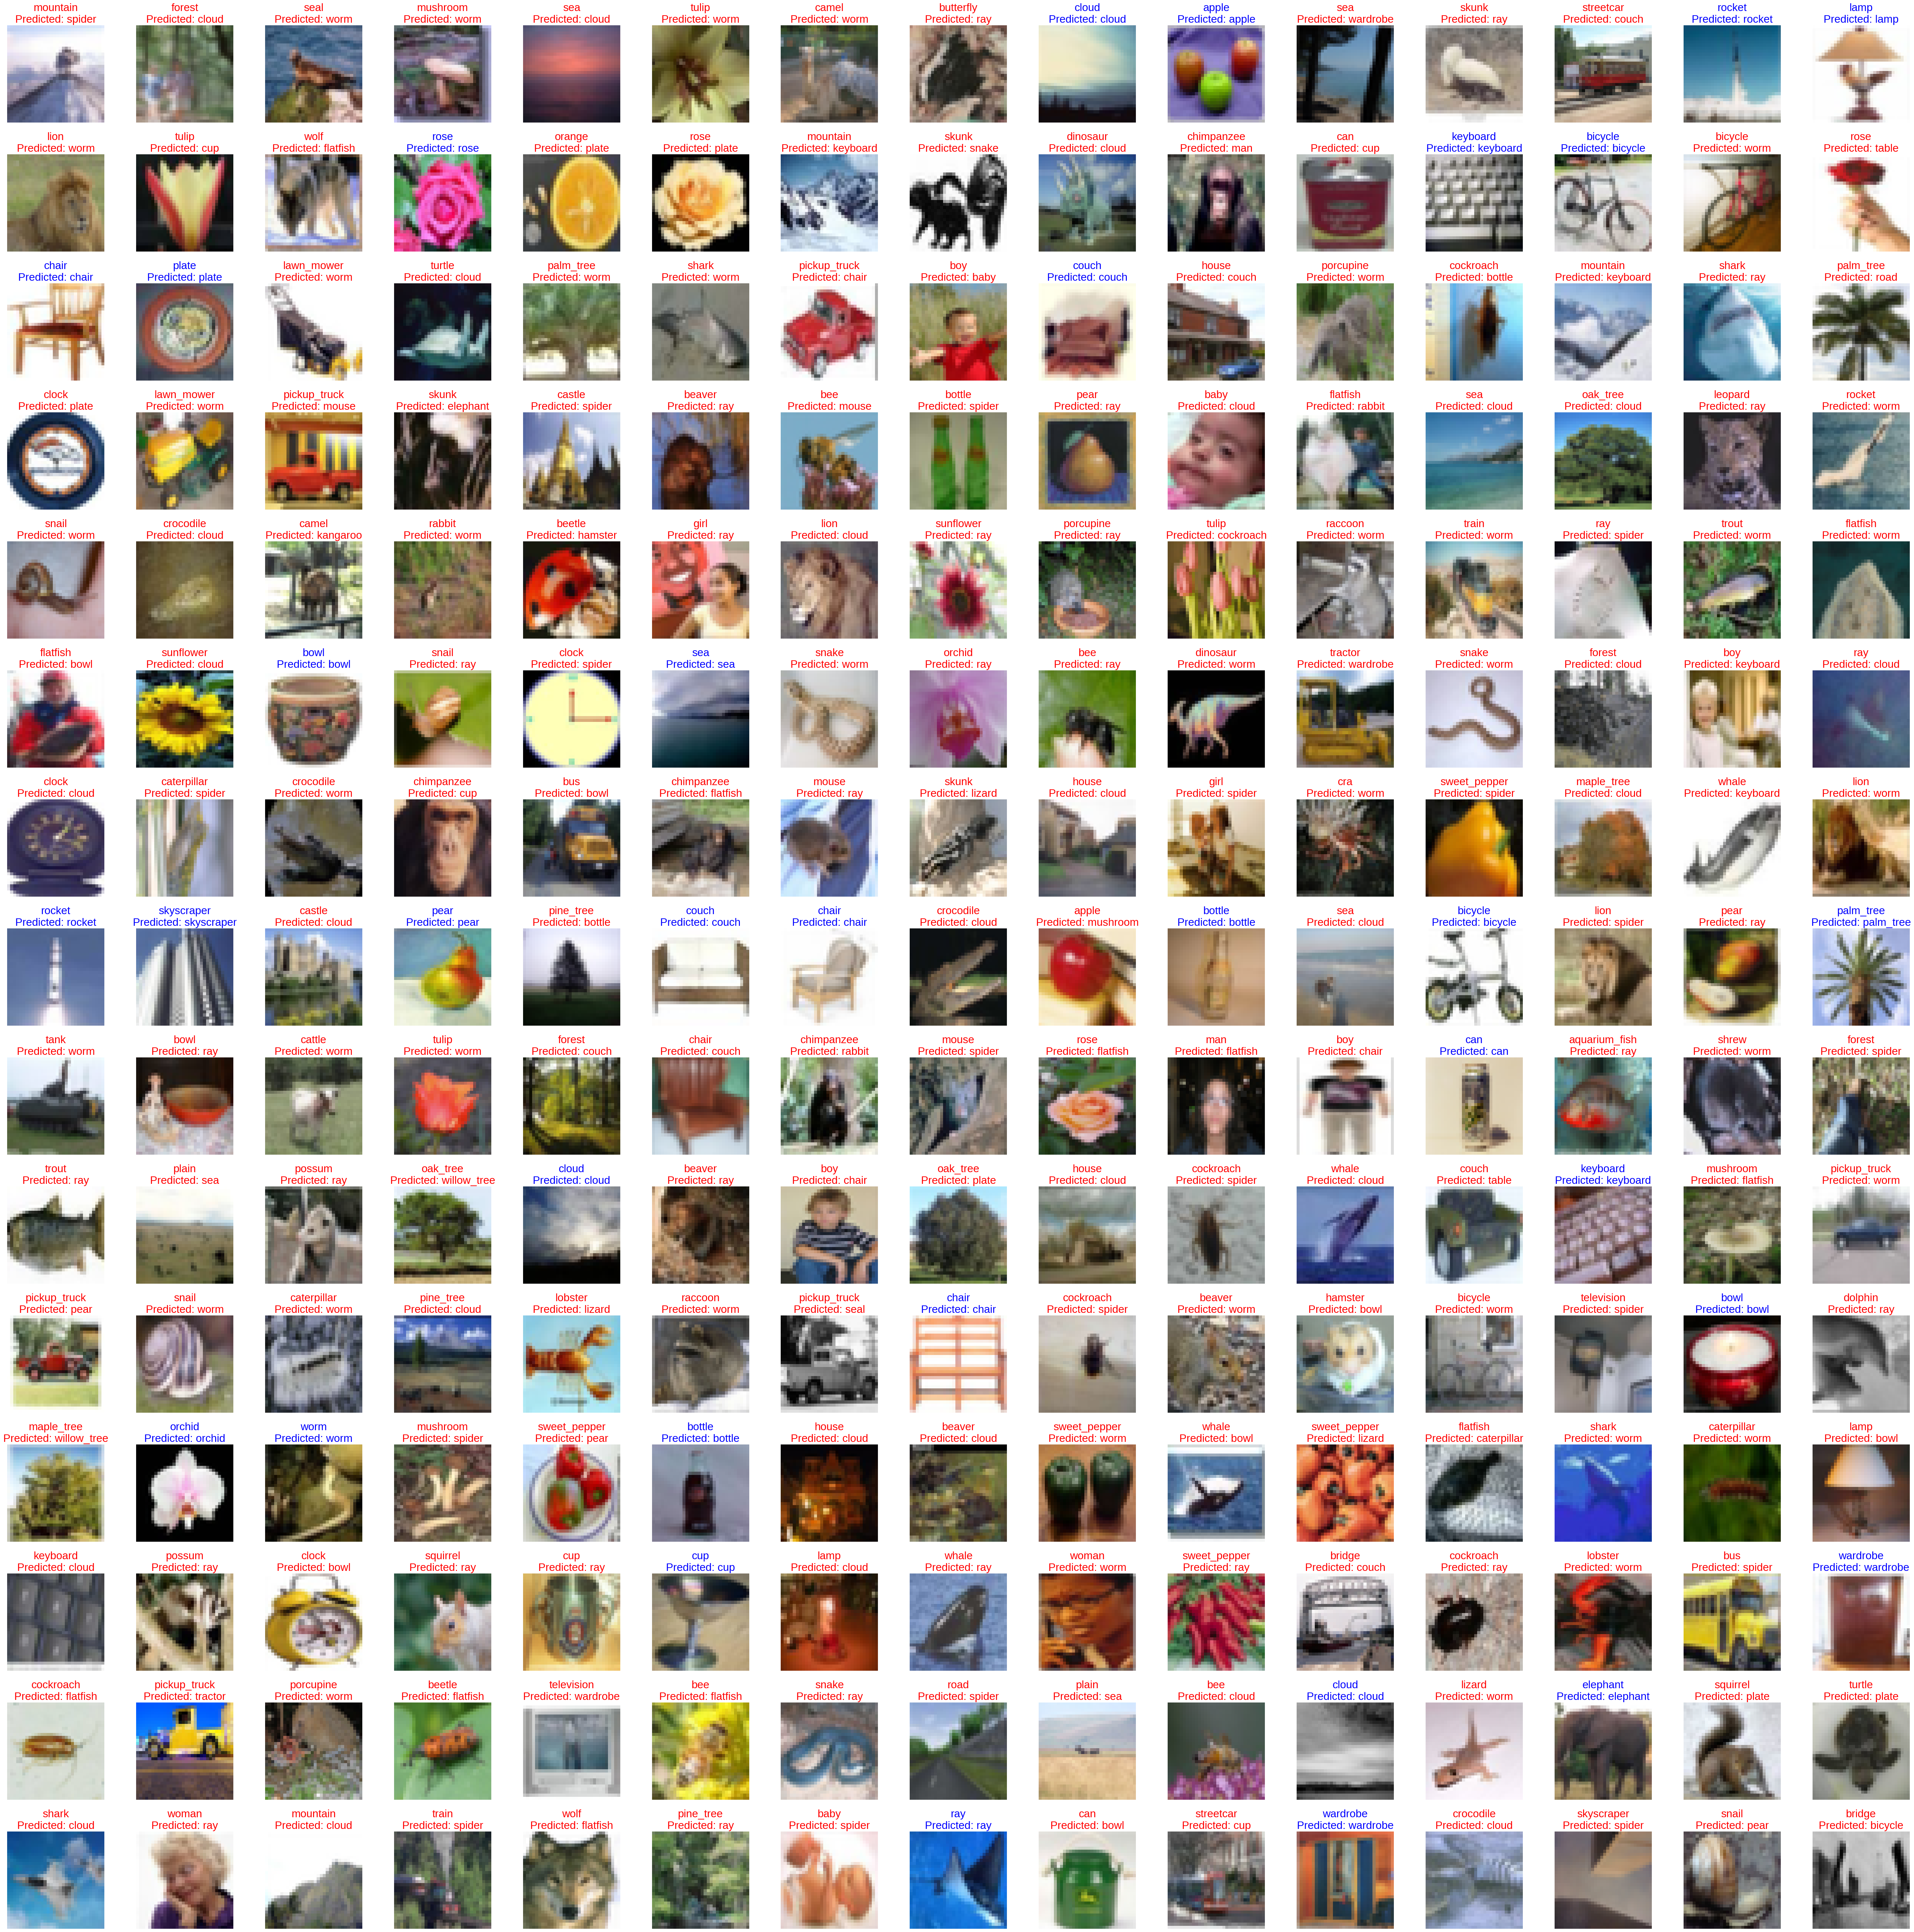

In [9]:
# Plot settings
panel_sz = 4
grid = 15
fig, axes = plt.subplots(nrows=grid, ncols=grid, figsize=(grid * panel_sz, grid * panel_sz))

# Visualization loop
for r in range(grid):
    for c in range(grid):
        ind = grid * r + c
        true_idx = int(y100_test_vis[ind])
        pred_idx = int(y_pred[ind])
        
        axes[r, c].imshow(x100_test_vis[ind])
        axes[r, c].set_xticks([])
        axes[r, c].set_yticks([])
        
        title = f'{classnames[true_idx]}\nPredicted: {classnames[pred_idx]}'
        color = 'blue' if true_idx == pred_idx else 'red'
        axes[r, c].set_title(title, color=color)

plt.tight_layout()
plt.show()

### 8f. Questions

**Question 5:** Take a look at the above montage. Does the mistakes made by ResNet-18 seem reasonable? Provide some specific examples to support your conclusion.

**Answer 5:**
Some of the mistakes are quite reasonable. For example, mistaking a snake for a worm or a cup for a can. But there a plenty of mistakes that don't make sense. It seems to perform poorly on these set of images.

## Extensions

### General guidelines

1. Never integrate extensions into your base project so that they change the expected behavior of core functions. If your extension changes the core design/behavior, no problem, duplicate your working base project and add features from there.
2. Check the rubric to keep in mind how extensions on this project will be graded.
3. While I may consult your code and "written log" of what you did, **I am grading your extensions based on what you present in your 3-5 min video.**
3. I suggest documenting your explorations in a "log" or "lab notebook" style (i.e. documenting your thought/progression/discovery/learning process). I'm not grading your writing, so you can keep it succinct. **Whatever is most useful to you to remember what you did.** 
4. I suggest taking a hypothesis driven approach. For example "I was curious about X so I explored Y. I found Z, which was not what I expected because..., so then tried A..."
5. Make plots to help showcase your results.
6. **More is not necessarily better.** Generally, a small number of "in-depth" extensions count for more than many "shallow" extensions.

### AI guidelines

You may use AI in mostly any capacity for extensions. However, keep in mind:
1. There is no need to use AI at all!
2. You are welcome to use AI as a tool (e.g. automate something that is tedious, help you get unstuck, etc.). However, you should be coding, you should be thinking, you should be writing, you should be creating. If you are spending most (or even close to most) of your time typing into a chatbot and copy-pasting, you have probably gone too far with AI use.
3. I don't find large volumes of AI generated code/text/plots to be particularly impressive and you risk losing my interest while grading. Remember: I'm grading your extensions based on your video presentation. **More is not necessarily better.**

### Video guidelines

1. Please try to keep your video to 5 minutes (*I have other projects to grade!*). If you turn in a longer video, I make no promise that I will watch more than 5 minutes.
2. Your screen should be shared as you show me what you did. A live video of your face should also appear somewhere on the screen (e.g. picture-in-picture overlay / split screen).
3. Your partner should join you for the video and take turns talking, but, if necessary, it is fine to have one team member present during the record the video.
4. Do not simply read text from your notebook, do not read from a prepared script. I am not grading how polished your video presentation is (see extension grading criteria on rubric). 
5. I am looking for original and creative explorations sparked by your curiosity/interest/passion in a topic. This should be apparent in your video.
6. Be natural,, don't feel the need to impress me with fancy language. If it is helpful, imagine that we are talking one-on-one about your extension. Tell me what you did :)

### Extension ideas

#### 1. ResNet-34

Create and train the well-known network of the ResNet family called ResNet-34. Here is a suggested network configuration to experiment with:

```
block_units = [64, 128, 256, 512]
num_blocks = [3, 4, 6, 3]
first_block_strides = [1, 2, 2, 2]
```

#### 2. ResNet-50

Create and train the well-known network of the ResNet family called ResNet-50. Given its depth, it uses a "Bottleneck block" rather than a normal Residual Block, but the overall structure is very similar. Here is a suggested network configuration to experiment with:

```
block_units = [64, 128, 256, 512]
num_blocks = [3, 4, 6, 3]
first_block_strides = [1, 2, 2, 2]
```

#### 3. VGG networks on CIFAR-100

How does one or more of your VGG networks do at classifying images in CIFAR-100?

#### 4. Other ResNets on CIFAR-10

How do the other ResNets do at classifying images in CIFAR-10?

#### 5. Multi-network comparison

Compare the accuracy, efficiency, etc of any number of networks from the VGG, Inception Net, and ResNet families.

#### 6. Add support for saving/loading network weights

A key limitation of your current deep learning library is that parameters that capture the learning in networks are completely reset/lost/wiped out when the notebook kernel is terminated. Add (and test!) support for saving network parameters to disk after (or periodically during) training. Add (and test!) support for loading network parameters back into the network from disk before training. 

Be careful to include the moving mean and standard deviation parameters in batch normalization layers otherwise the whole net will not work!

#### 7. Other image datasets

Apply any of the three deep network families to another dataset of your choice. 

#### 8. Hyperparameter tuning

Try and find hyperparameters that allow Inception Net and the ResNets to achieve better accuracy on CIFAR-10 and/or CIFAR-100.

#### 9. Build other Inception Nets

We only built a single network, but just like VGG and ResNet, you can modify the network depth while following the computational motifs of the Inception Net architecture. Design and experiment with your own Inception Net!

#### 10. Analyze errors made by one or more of the nets

Make a confusion matrix for CIFAR-10 or CIFAR-100 (*a challenge to make it useful!*).

Visualize the predictions made by Inception Net and/or a VGG net, perhaps similar what was done with the ResNet.